In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
np.random.seed(1234)
%config InlineBackend.figure_format = 'retina'
plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])

#### Code 5.1

In [2]:
# load data
d = pd.read_csv('Data/WaffleDivorce.csv', sep=';')
# standardize predictor
d['MedianAgeMarriage_s'] = (d.MedianAgeMarriage - d.MedianAgeMarriage.mean()) / d.MedianAgeMarriage.std()

In [3]:
with pm.Model() as model_5_1:
    a = pm.Normal('a', mu=10, sd=10)
    bA = pm.Normal('bA', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    # good (default) alternatives for sigma (in this and other models) are
    # sigma = pm.HalfNormal('sigma', 5)
    # sigma = pm.HalfCauchy('sigma', 5)
    # some people recomed avoiding "hard" boundaries unless they have a theoretical/data-based justification, like a correlation that is restricted to be [-1, 1].
    mu = pm.Deterministic('mu', a + bA * d.MedianAgeMarriage_s)
    Divorce = pm.Normal('Divorce', mu=mu, sd=sigma, observed=d.Divorce)
    trace_5_1 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bA, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:02<00:00, 1608.05draws/s]


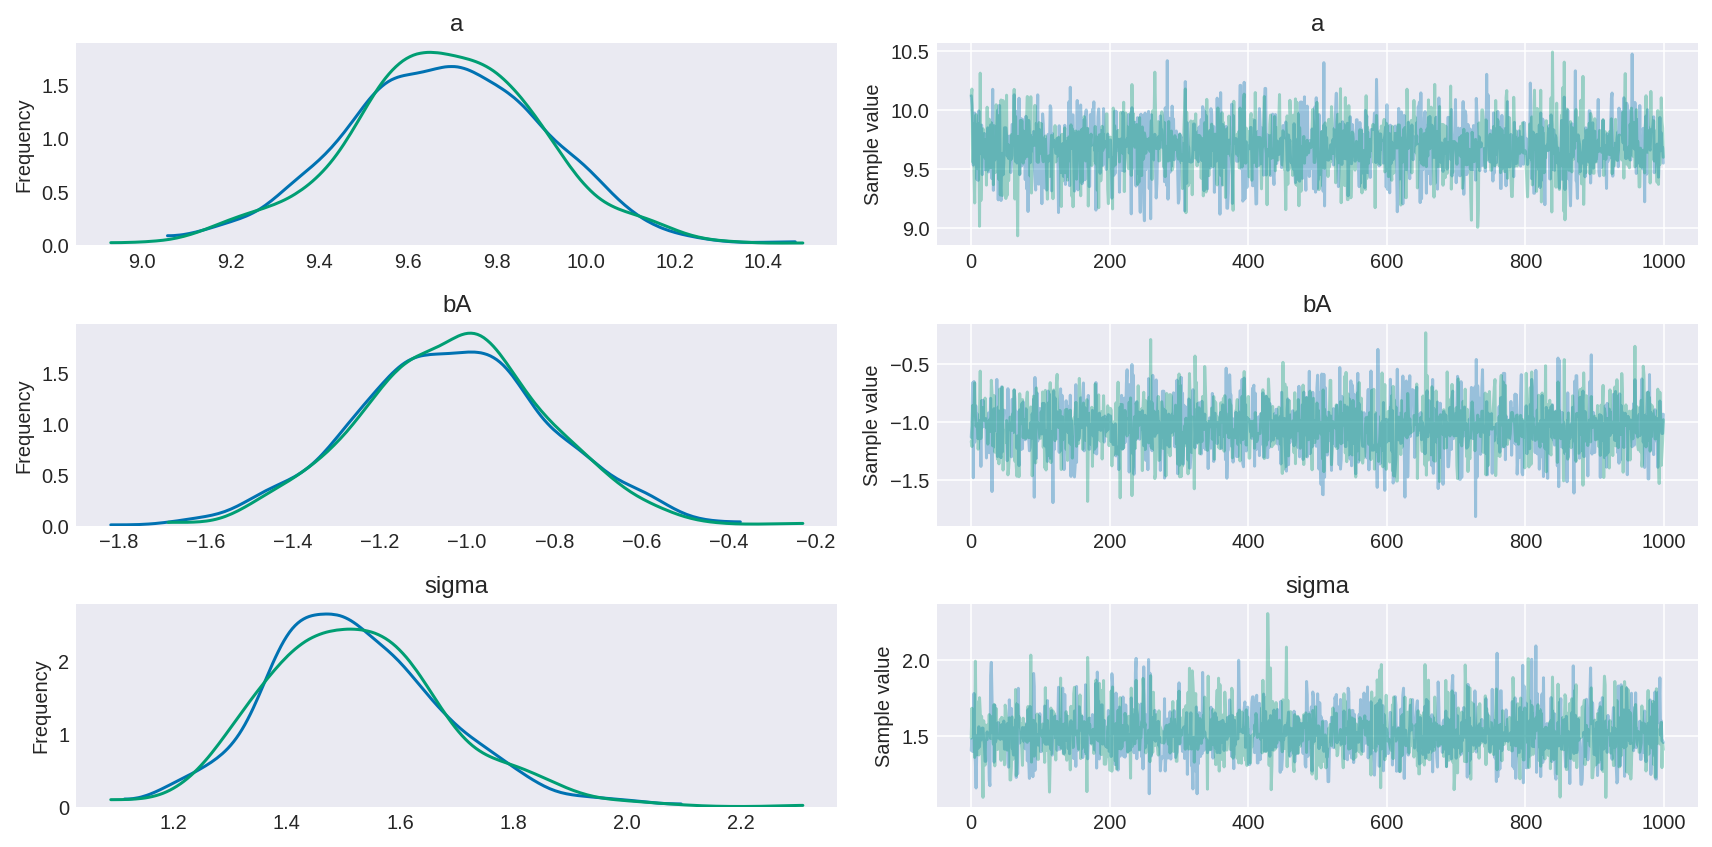

In [4]:
varnames = ['a', 'bA', 'sigma']
pm.traceplot(trace_5_1, varnames);

#### Code 5.2

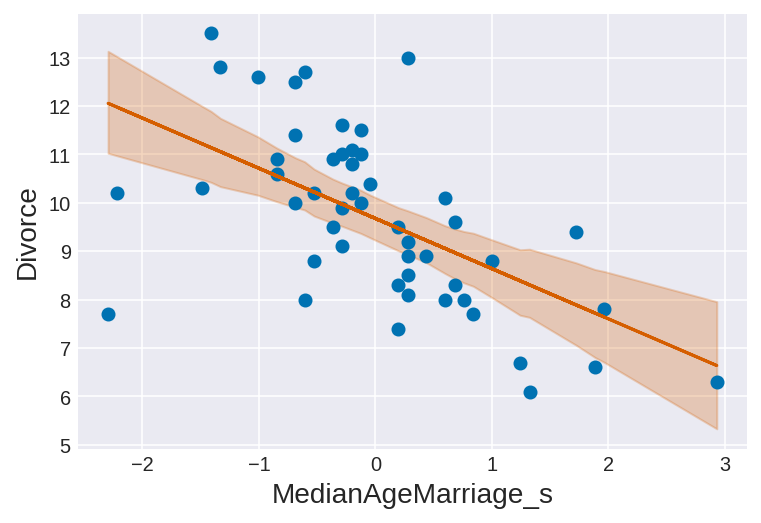

In [5]:
mu_mean = trace_5_1['mu']
mu_hpd = pm.hpd(mu_mean)

plt.plot(d.MedianAgeMarriage_s, d.Divorce, 'C0o')
plt.plot(d.MedianAgeMarriage_s, mu_mean.mean(0), 'C2')

idx = np.argsort(d.MedianAgeMarriage_s)
plt.fill_between(d.MedianAgeMarriage_s[idx],
                 mu_hpd[:,0][idx], mu_hpd[:,1][idx], color='C2', alpha=0.25)

plt.xlabel('MedianAgeMarriage_s', fontsize=14)
plt.ylabel('Divorce', fontsize=14);

If you inspect the output, you’ll see that each additional standard deviation of delay in marriage (1.24 years) predicts a decrease of about one divorce per thousand adults(-1.05), with a 89% interval from about −1.4 to −0.7.

In [6]:
pm.summary(trace_5_1, varnames=['a', 'bA', 'sigma'], alpha=.11).round(2)

mean    sd  mc_error  hpd_5.5  hpd_94.5    n_eff  Rhat
a      9.68  0.22       0.0     9.32     10.03  2801.29   1.0
bA    -1.04  0.22       0.0    -1.40     -0.70  2676.13   1.0
sigma  1.52  0.16       0.0     1.26      1.76  2241.64   1.0

#### Code 5.3

In [7]:
d['Marriage_s'] = (d.Marriage - d.Marriage.mean()) / d.Marriage.std()

In [8]:
with pm.Model() as model_5_2:
    a = pm.Normal('a', mu=10, sd=10)
    bA = pm.Normal('bA', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    mu = pm.Deterministic('mu', a + bA * d.Marriage_s)
    Divorce = pm.Normal('Divorce', mu=mu, sd=sigma, observed=d.Divorce)
    trace_5_2 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bA, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:02<00:00, 1560.47draws/s]


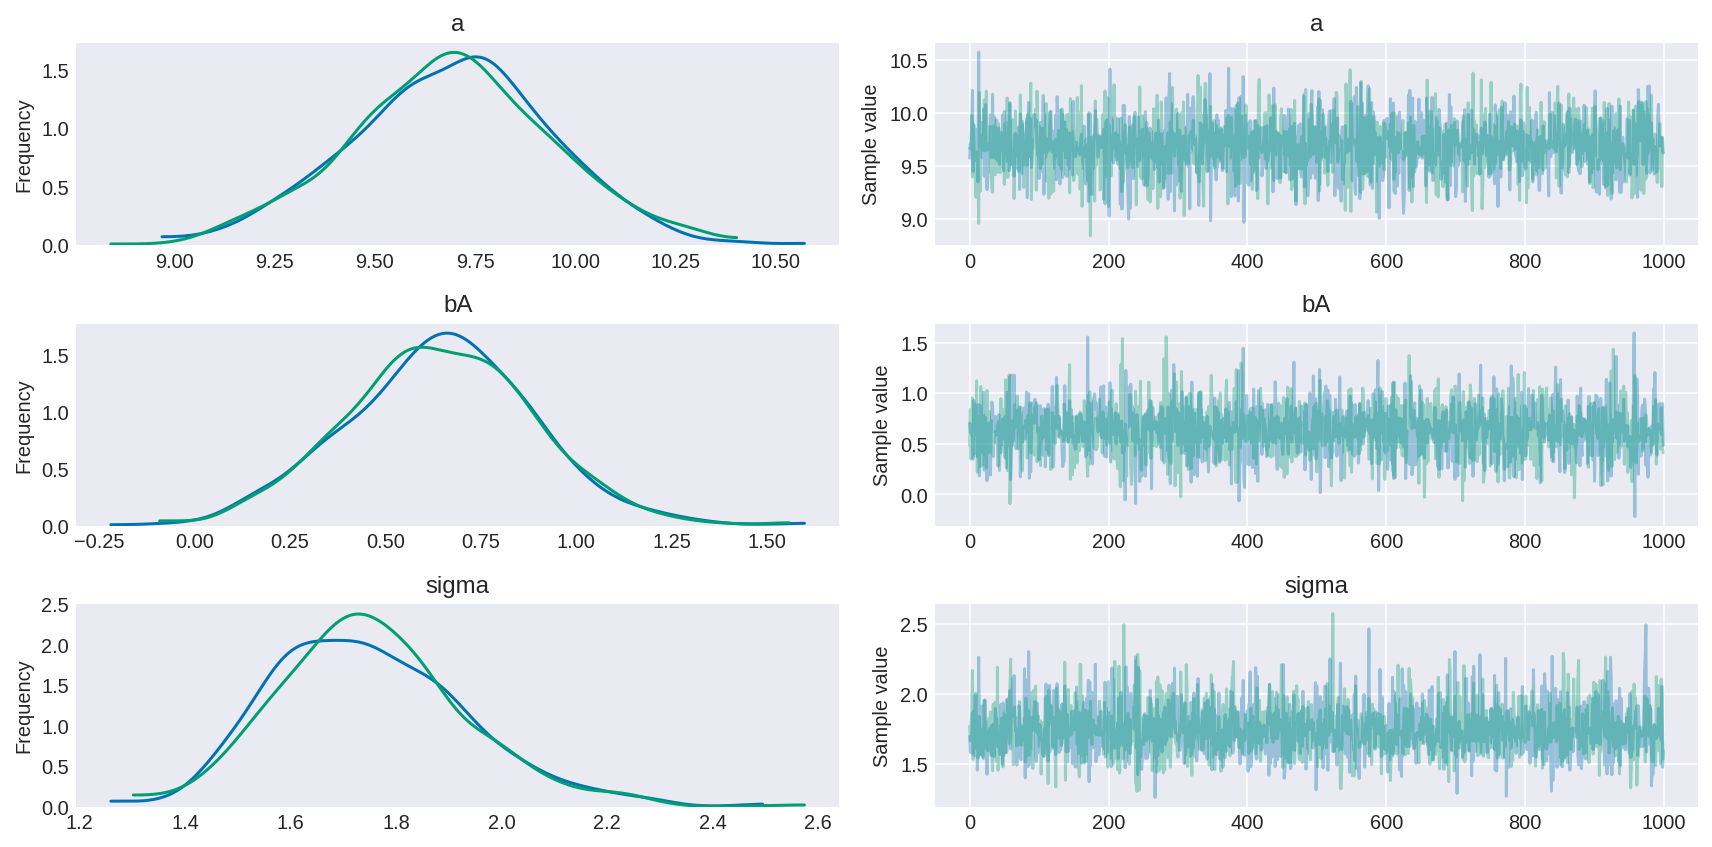

In [9]:
pm.traceplot(trace_5_2, varnames);

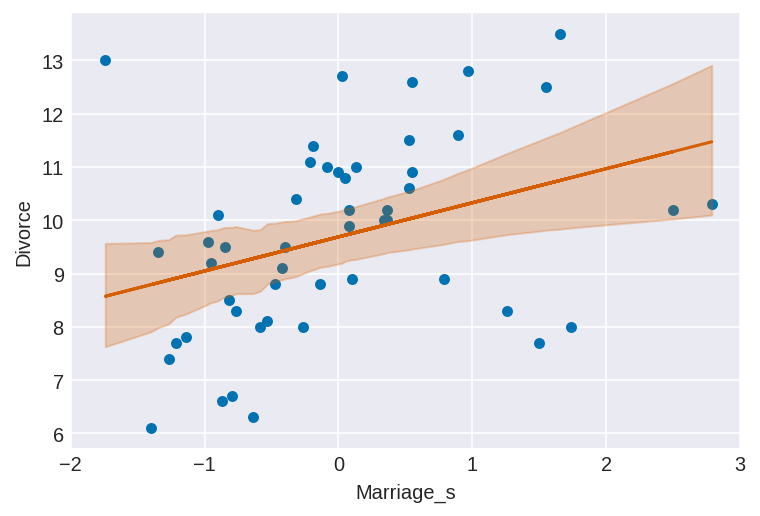

In [10]:
mu_mean = trace_5_2['mu']
mu_hpd = pm.hpd(mu_mean)

d.plot('Marriage_s', 'Divorce', kind='scatter', xlim = (-2, 3))
plt.plot(d.Marriage_s, mu_mean.mean(0), 'C2')

idx = np.argsort(d.Marriage_s)
plt.fill_between(d.Marriage_s[idx], mu_hpd[:,0][idx], mu_hpd[:,1][idx],
                 color='C2', alpha=0.25);

And this shows an increase of 0.6 divorces for every additional standard deviation of marriage rate (3.8). As you may intuit and see in the figure, this relationship isn’t as strong as the previous one.

In [11]:
pm.summary(trace_5_2, varnames=['a', 'bA', 'sigma'], alpha=.11).round(2)

mean    sd  mc_error  hpd_5.5  hpd_94.5    n_eff  Rhat
a      9.69  0.25       0.0     9.29     10.11  2569.53   1.0
bA     0.64  0.24       0.0     0.24      1.02  2466.64   1.0
sigma  1.75  0.18       0.0     1.47      2.03  2347.65   1.0

#### Code 5.4

In [12]:
with pm.Model() as model_5_3:
    a = pm.Normal('a', mu=10, sd=10)
    bA = pm.Normal('bA', mu=0, sd=1)
    bR = pm.Normal('bR', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    mu = pm.Deterministic('mu', a + bR * d.Marriage_s + bA * d.MedianAgeMarriage_s)    
    Divorce = pm.Normal('Divorce', mu=mu, sd=sigma, observed=d.Divorce)
    trace_5_3 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bR, bA, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:03<00:00, 1075.31draws/s]


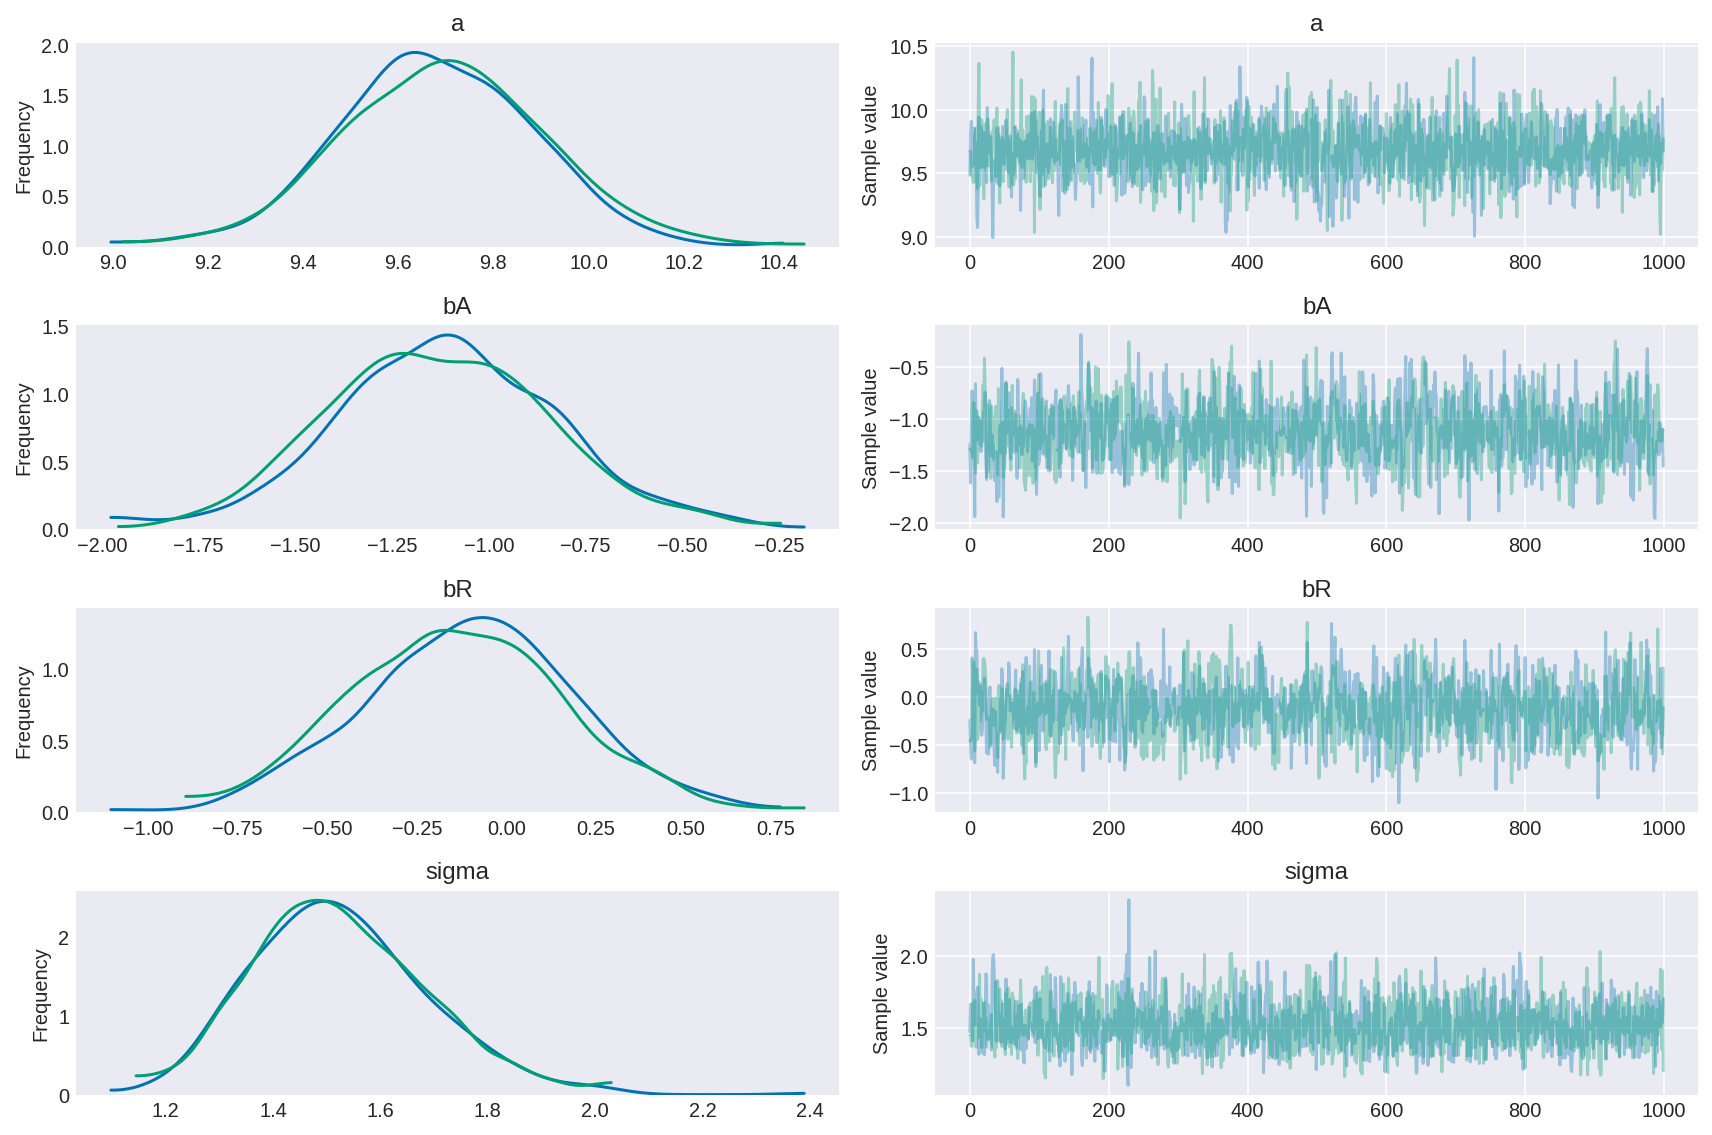

In [13]:
varnames = ['a', 'bA', 'bR', 'sigma']
pm.traceplot(trace_5_3, varnames);

In [14]:
pm.summary(trace_5_3, varnames, alpha=.11).round(3)

mean     sd  mc_error  hpd_5.5  hpd_94.5     n_eff   Rhat
a      9.685  0.211     0.005    9.349    10.003  1803.147  1.002
bA    -1.121  0.287     0.008   -1.575    -0.670  1061.368  1.001
bR    -0.124  0.295     0.009   -0.619     0.331   998.912  1.003
sigma  1.523  0.162     0.004    1.278     1.774  1315.034  1.000

#### Code 5.5

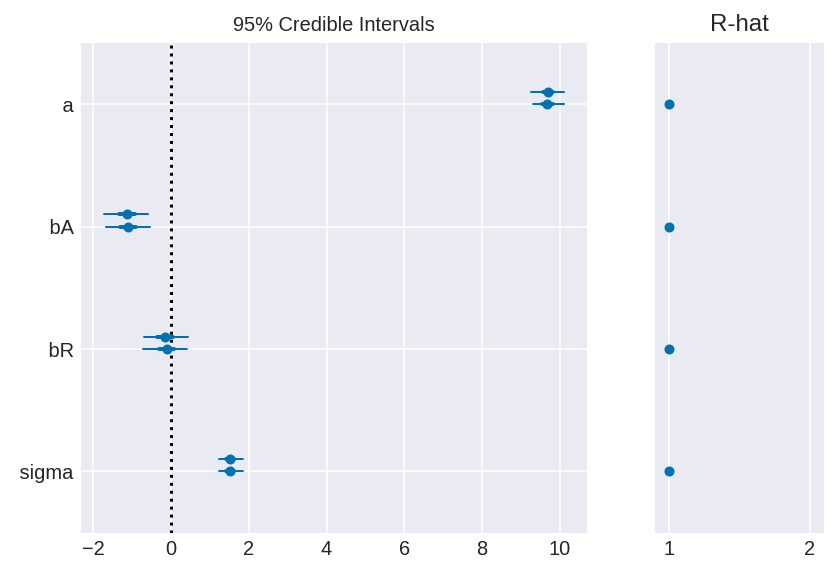

In [15]:
pm.forestplot(trace_5_3, varnames=varnames);

## Diagnostics

### Predictor residual plots

### The general method is:
* model each predictor vs all other predictors
* calculate residuals of predictor data - predictor model
* model outcome vs residuals for each predictor
* this gives the effect of each predictor, when controlling for all the other predictors

#### Code 5.6 - Model a predictor of interest by using ALL other predictors

In [16]:
with pm.Model() as model_5_4:
    a = pm.Normal('a', mu=10, sd=10)
    b = pm.Normal('b', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    mu = pm.Deterministic('mu', a + b * d.MedianAgeMarriage_s)
    Marriage = pm.Normal('Marriage', mu=mu, sd=sigma, observed=d.Marriage_s)
    trace_5_4 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:04<00:00, 974.68draws/s] 


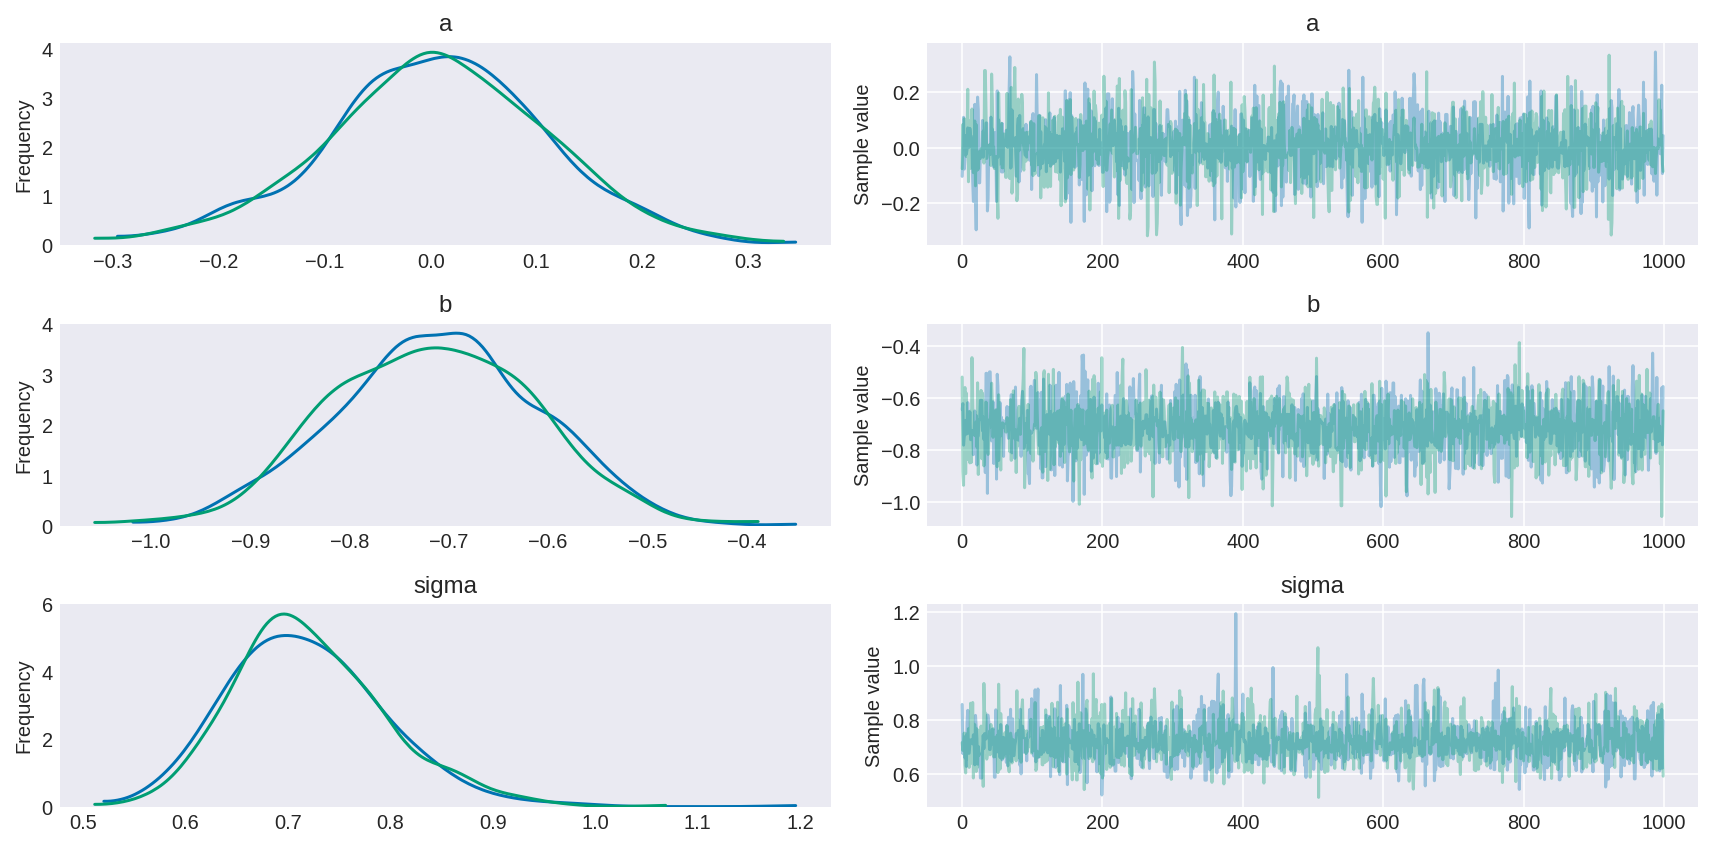

In [17]:
varnames = ['a', 'b', 'sigma']
pm.traceplot(trace_5_4, varnames);

#### Code 5.7 & 5.8 Calculate and plot residuals

When a residual is positive, that means that the observed rate was in excess of what we’d expect, given the median age at marriage in that State. When a residual is negative, that means the observed rate was below what we’d expect. In simpler terms, States with positive residuals marry fast for their age of marriage, while States with negative residuals marry slow for their age of marriage. 

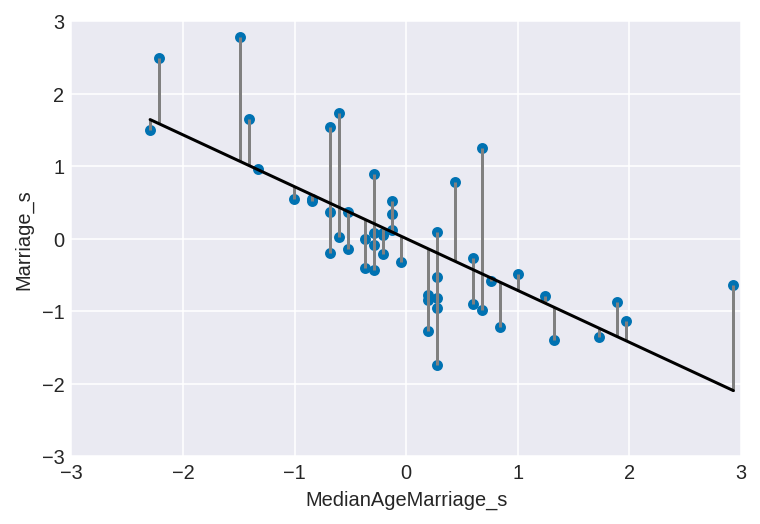

In [18]:
mu_pred = trace_5_4['mu'].mean(0)
residuals = d.Marriage_s - mu_pred
idx = np.argsort(d.MedianAgeMarriage_s)
d.plot('MedianAgeMarriage_s', 'Marriage_s', kind='scatter', xlim = (-3, 3), ylim = (-3, 3))
plt.plot(d.MedianAgeMarriage_s[idx], mu_pred[idx], 'k')
plt.vlines(d.MedianAgeMarriage_s, mu_pred, mu_pred + residuals, colors='grey');

In [19]:
# model for predicting MedianAgeMarriage_s
with pm.Model() as model_5_4_a:
    a = pm.Normal('a', mu=10, sd=10)
    b = pm.Normal('b', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    mu = pm.Deterministic('mu', a + b * d.Marriage_s)
    Marriage = pm.Normal('Marriage', mu=mu, sd=sigma, observed=d.MedianAgeMarriage_s)
    trace_5_4_a = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:02<00:00, 1336.50draws/s]


Plot effect of marriage rate (left) and marriage age (right) on divorce, having controlled for marriage age and marriage age respectively. The control is that we are plotting the residuals of the fit of marriage rate vs marriage age (left) and marriage age vs marriage rate (right), so it's what's left of the effect of marriage rate and marriage rate after we remove each other.

So essentially this analysis is telling as what awe already know from the multivariate model, see `Code 5.5` 
```python
pm.forestplot(trace_5_3, varnames=varnames);
```

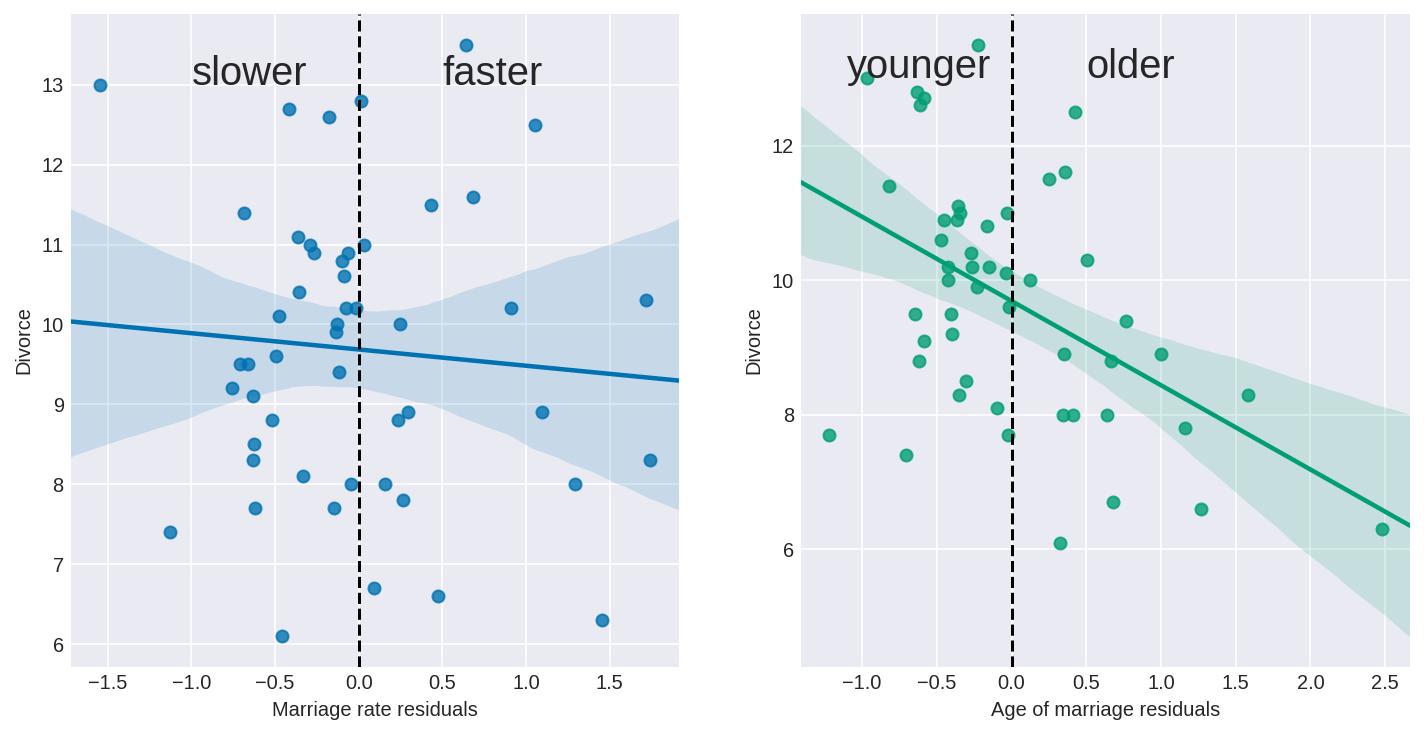

In [20]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
sns.regplot(ax=ax[0], x=residuals, y=d.Divorce)
sns.regplot(ax=ax[1], x=d.MedianAgeMarriage_s - trace_5_4_a['mu'].mean(0), y=d.Divorce);
ax[0].axvline(x=0,color='k',ls='--')
ax[1].axvline(x=0,color='k',ls='--')
ax[0].text(-1,13,'slower',size=20)
ax[0].text(0.5,13,'faster',size=20)
ax[1].text(-1.1,13,'younger',size=20)
ax[1].text(0.5,13,'older',size=20)
ax[0].set_xlabel('Marriage rate residuals');
ax[1].set_xlabel('Age of marriage residuals');

So what’s the point of all of this? There’s direct value in seeing the model-based predictions displayed against the outcome, after subtracting out the influence of other predictors. The plots in Figure 5.4 do this. But this procedure also brings home the message that regression models answer with the remaining association of each predictor with the outcome, after already knowing the other predictors. In computing the predictor residual plots, you had to perform those calculations yourself.

### Counterfactual plots
The simplest use of a counterfactual plot is to see how the predictions change as you
change only one predictor at a time. This means holding the values of all predictors constant,
except for a single predictor of interest. Such predictions will not necessarily look like your
raw data—they are counterfactual after all—but they will help you understand the implications of the model.

#### Code 5.9 & 5.10

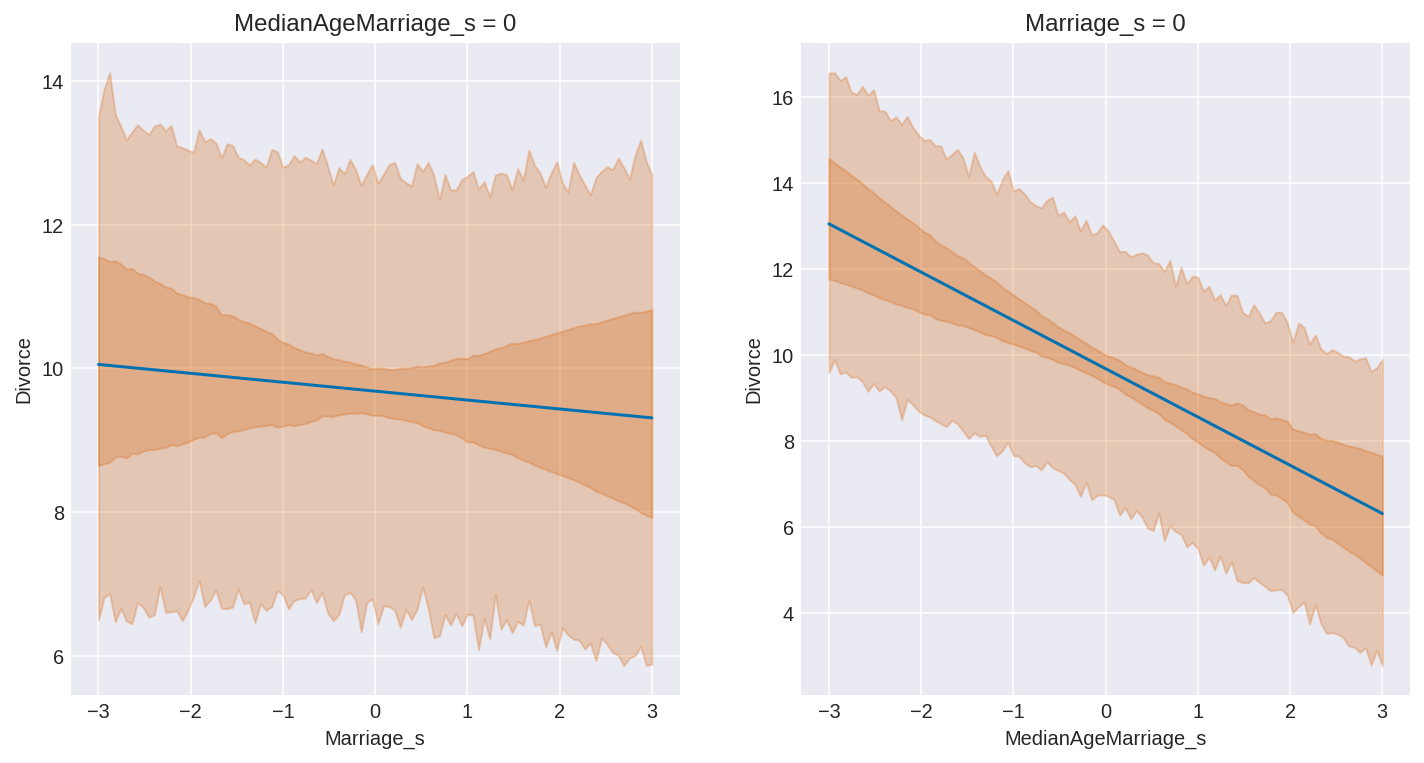

In [21]:
R_avg = np.linspace(-3, 3, 100)
# plot predictions of Divorce from changes in marriage age while keeping marriage rate constant.
# If we use the mean of the predictor then the results is zero and we can omit it from the model below
# if the predictors are not standardize then we need to include it in the model (as coefficient x mean(predictor))
mu_pred_age = trace_5_3['a'] + trace_5_3['bA'] * R_avg[:,None]
mu_hpd_age = pm.hpd(mu_pred_age.T, alpha=0.11)
divorce_hpd_age = pm.hpd(stats.norm.rvs(mu_pred_age, trace_5_3['sigma']).T)

mu_pred_rate = trace_5_3['a'] + trace_5_3['bR'] * R_avg[:,None]
mu_hpd_rate = pm.hpd(mu_pred_rate.T, alpha=0.11)
divorce_hpd_rate = pm.hpd(stats.norm.rvs(mu_pred_rate, trace_5_3['sigma']).T)

fig , ax = plt.subplots(1,2,figsize=(12,6))
ax[0].plot(R_avg, mu_pred_rate.mean(1), 'C0');
ax[0].fill_between(R_avg, mu_hpd_rate[:,0], mu_hpd_rate[:,1], color='C2', alpha=0.25)
ax[0].fill_between(R_avg, divorce_hpd_rate[:,0], divorce_hpd_rate[:,1], color='C2', alpha=0.25)
ax[0].set_xlabel('Marriage_s')
ax[0].set_ylabel('Divorce')
ax[0].set_title('MedianAgeMarriage_s = 0');

ax[1].plot(R_avg, mu_pred_age.mean(1), 'C0');
ax[1].fill_between(R_avg, mu_hpd_age[:,0], mu_hpd_age[:,1], color='C2', alpha=0.25)
ax[1].fill_between(R_avg, divorce_hpd_age[:,0], divorce_hpd_age[:,1], color='C2', alpha=0.25)
ax[1].set_xlabel('MedianAgeMarriage_s')
ax[1].set_ylabel('Divorce')
ax[1].set_title('Marriage_s = 0');

#### Code 5.11

In [22]:
mu_pred = trace_5_3['mu']
mu_hpd = pm.hpd(mu_pred)

divorce_pred = pm.sample_ppc(trace_5_3, samples=1000, model=model_5_3)['Divorce']
divorce_hpd = pm.hpd(divorce_pred)

/home/damianos/.conda/envs/pymc3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  after removing the cwd from sys.path.
100%|██████████| 1000/1000 [00:00<00:00, 1665.63it/s]


#### Code 5.12

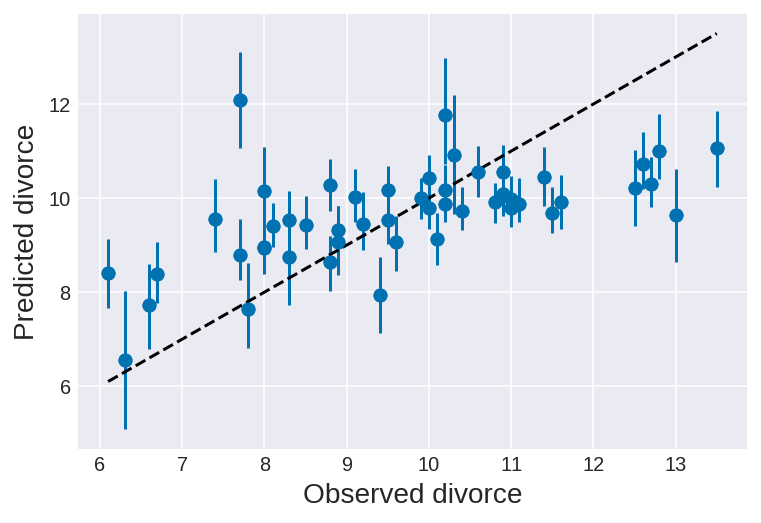

In [23]:
mu_hpd = pm.hpd(mu_pred, alpha=0.05)
plt.errorbar(d.Divorce, divorce_pred.mean(0), yerr=np.abs(divorce_pred.mean(0)-mu_hpd.T) , fmt='C0o')
plt.plot(d.Divorce, divorce_pred.mean(0), 'C0o')

plt.xlabel('Observed divorce', fontsize=14)
plt.ylabel('Predicted divorce', fontsize=14)

min_x, max_x = d.Divorce.min(), d.Divorce.max()
plt.plot([min_x, max_x], [min_x, max_x], 'k--');

#### Code 5.14

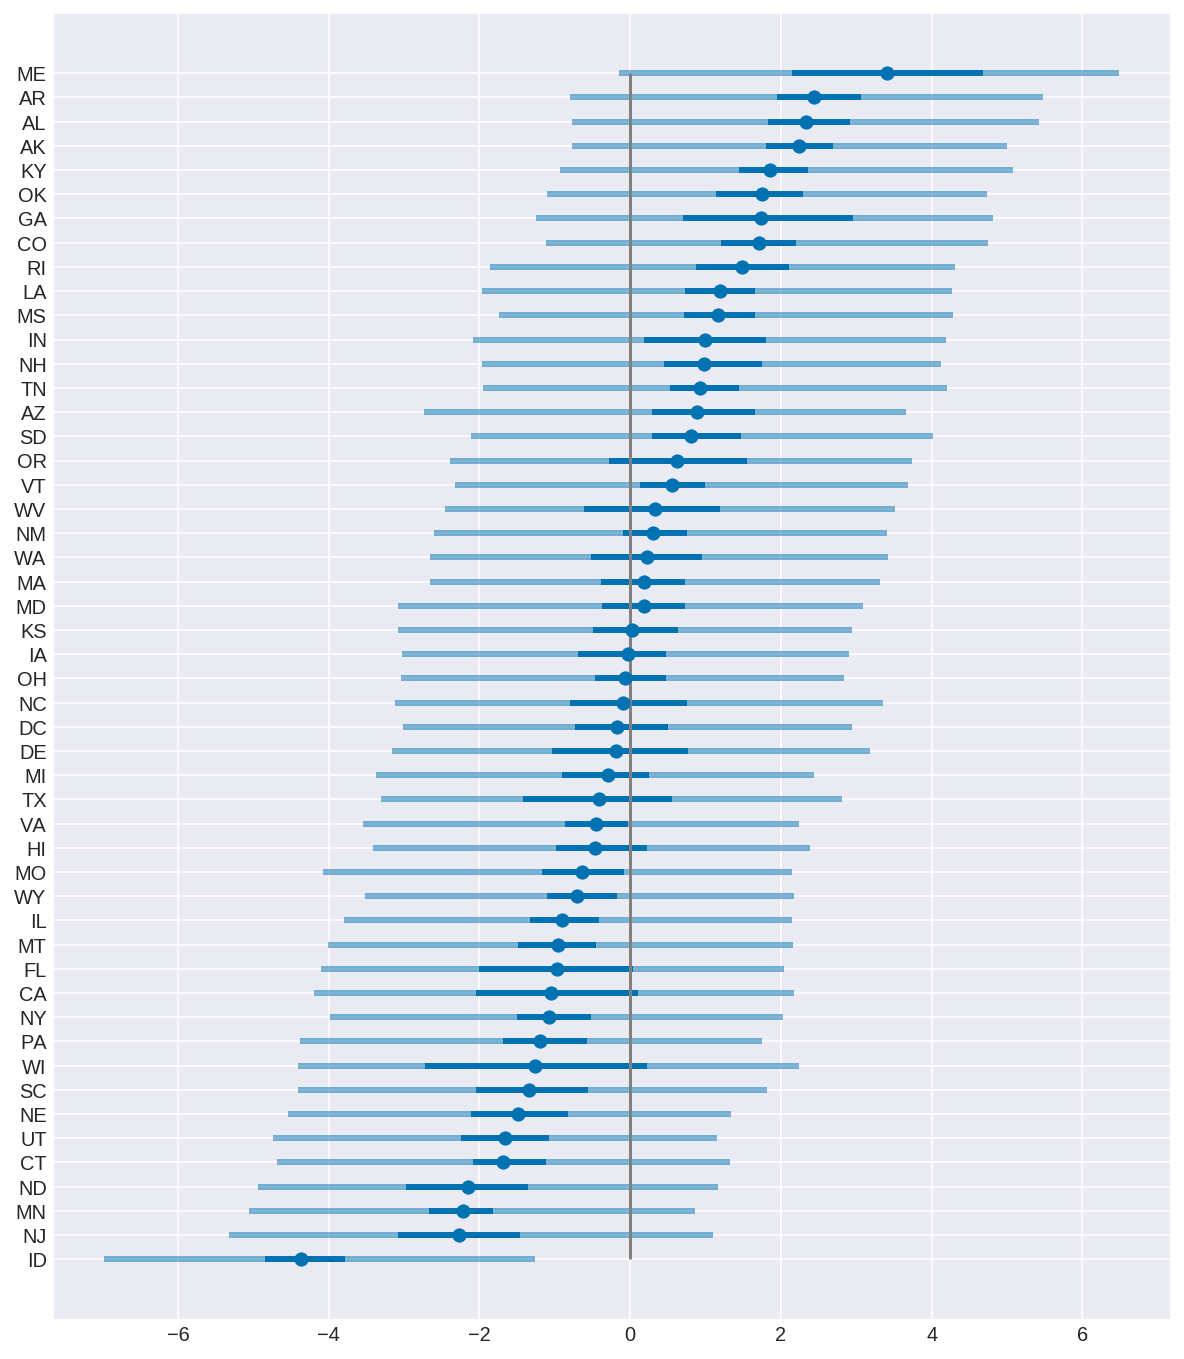

In [24]:
plt.figure(figsize=(10,12))
residuals = d.Divorce - mu_pred.mean(0)
idx = np.argsort(residuals)
y_label = d.Loc[idx]
y_points = np.linspace(0, 1, 50)
plt.errorbar(residuals[idx], y_points, 
             xerr=np.abs(divorce_pred.mean(0)-mu_hpd.T),
             fmt='C0o',lw=3)

plt.errorbar(residuals[idx], y_points, 
             xerr=np.abs(divorce_pred.mean(0)-divorce_hpd.T),
             fmt='C0o', lw=3, alpha=0.5)

plt.yticks(y_points, y_label);
plt.vlines(0, 0, 1, 'grey');

### Important: Yet another common use for these simulations is to construct novel predictor residual plots. Once you’ve computed the divorce residuals, as you did just above, you can plot those residuals against new predictor variables. This is a quick way to see if remaining variation in the outcome is associated with another predictor.

#### Code 5.15

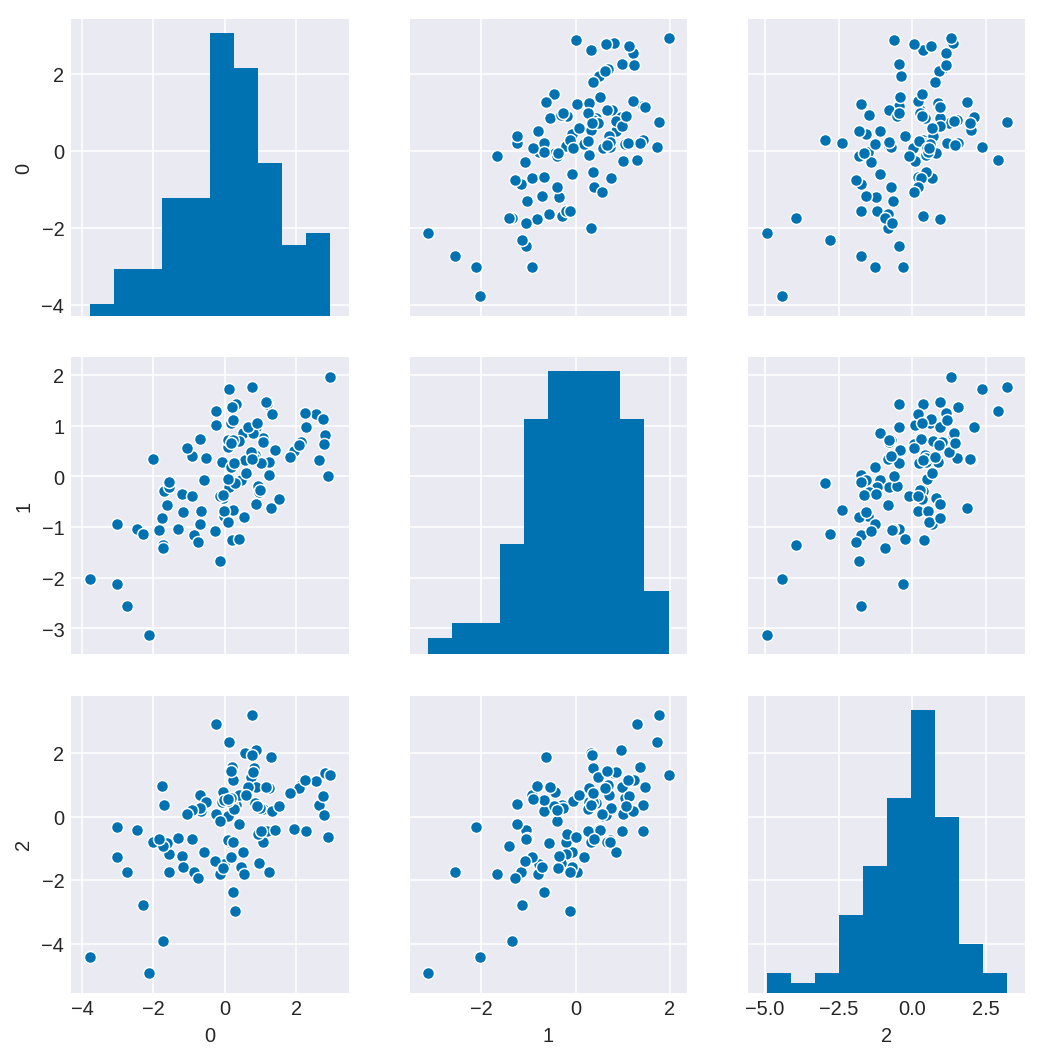

In [25]:
N = 100
x_real = stats.norm.rvs(size=N)
x_spur = stats.norm.rvs(x_real)
y = stats.norm.rvs(x_real)
d = pd.DataFrame([y, x_real, x_spur]).T

sns.pairplot(d);

In [26]:
with pm.Model() as model_spurious:
    a = pm.Normal('a', mu=10, sd=10)
    bReal = pm.Normal('bReal', mu=0, sd=1)
    bFake = pm.Normal('bFake', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    mu = pm.Deterministic('mu', a + bReal * x_real + bFake * x_spur)    
    Divorce = pm.Normal('Divorce', mu=mu, sd=sigma, observed=y)
    trace_spurious = pm.sample(1000, tune=1000)
pm.summary(trace_spurious, ['a','bReal','bFake'], alpha=.11).round(3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bFake, bReal, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:05<00:00, 755.73draws/s] 


mean     sd  mc_error  hpd_5.5  hpd_94.5     n_eff  Rhat
a      0.142  0.111     0.002   -0.046     0.308  1707.648   1.0
bReal  0.810  0.146     0.003    0.600     1.060  1831.494   1.0
bFake  0.115  0.098     0.002   -0.049     0.256  1829.891   1.0

when you include both x variables in a linear regression predicting y, the posterior mean for the association between y and x_spur will be close to zero, while the comparable mean for x_real will be closer to 1.

#### Code 5.16

In [27]:
d = pd.read_csv('Data/milk.csv', sep=';')
d.head()

clade         species  kcal.per.g  perc.fat  perc.protein  \
0  Strepsirrhine  Eulemur fulvus        0.49     16.60         15.42   
1  Strepsirrhine        E macaco        0.51     19.27         16.91   
2  Strepsirrhine        E mongoz        0.46     14.11         16.85   
3  Strepsirrhine   E rubriventer        0.48     14.91         13.18   
4  Strepsirrhine     Lemur catta        0.60     27.28         19.50   

   perc.lactose  mass  neocortex.perc  
0         67.98  1.95           55.16  
1         63.82  2.09             NaN  
2         69.04  2.51             NaN  
3         71.91  1.62             NaN  
4         53.22  2.19             NaN

#### Code 5.17 to 5.20

In [28]:
dcc = d.dropna().copy()

In [29]:
with pm.Model() as model_5_5:
    a = pm.Normal('a', mu=10, sd=100)
    bn = pm.Normal('bn', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=1)
    mu = pm.Deterministic('mu', a + bn * dcc['neocortex.perc'])
    kcal = pm.Normal('kcal', mu=mu, sd=sigma, observed=dcc['kcal.per.g'])
    trace_5_5 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bn, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:14<00:00, 192.48draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


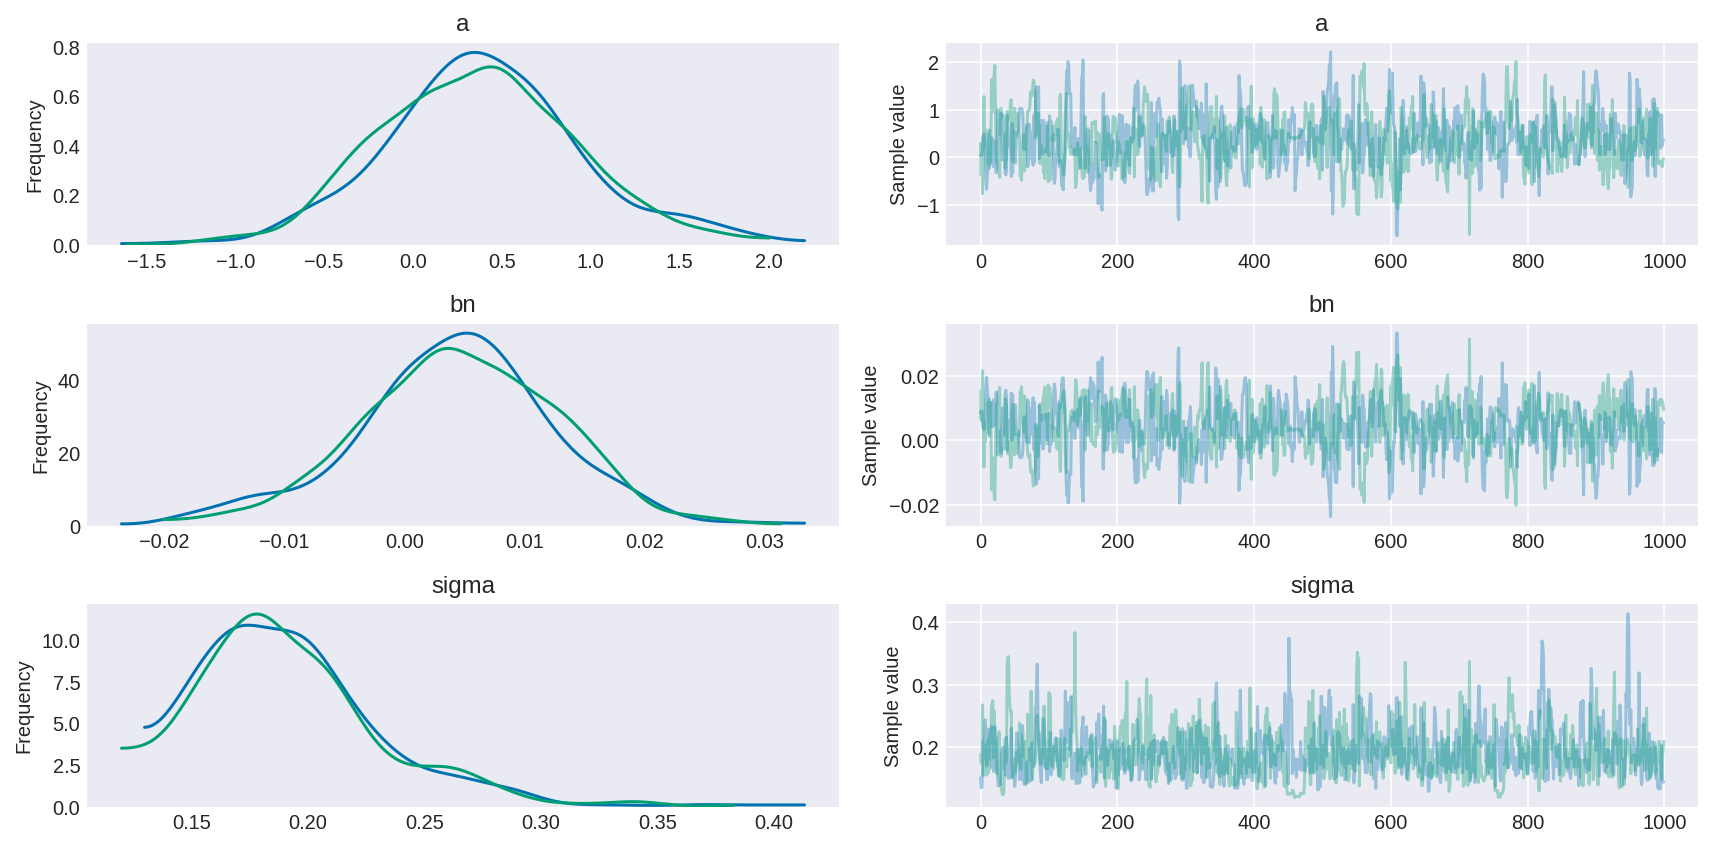

In [30]:
varnames = ['a', 'bn', 'sigma']
pm.traceplot(trace_5_5, varnames);

#### Code 5.21

In [31]:
pm.summary(trace_5_5, varnames, alpha=.11).round(3)

mean     sd  mc_error  hpd_5.5  hpd_94.5    n_eff   Rhat
a      0.371  0.553     0.022   -0.561     1.196  482.268  1.001
bn     0.004  0.008     0.000   -0.008     0.018  483.935  1.001
sigma  0.192  0.040     0.002    0.132     0.250  499.281  1.000

#### Code 5.22

In [32]:
trace_5_5['bn'].mean() * (76 - 55)

0.0891384399737767

#### Code 5.23

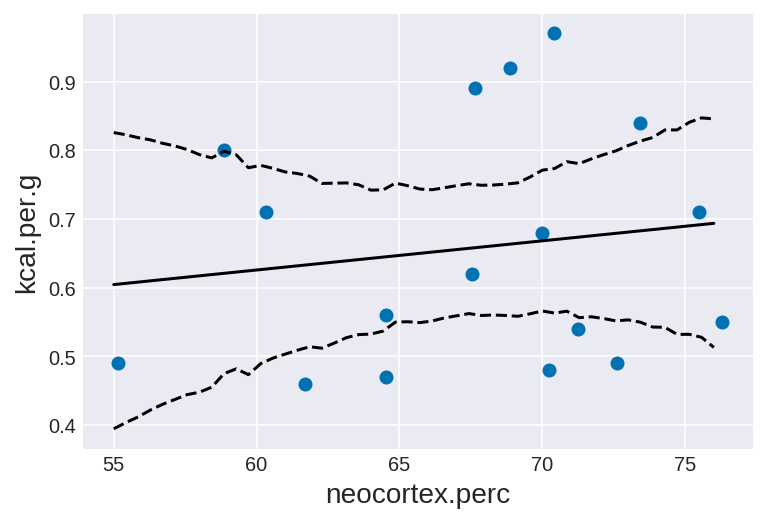

In [33]:
seq = np.linspace(55, 76, 50)
mu_pred = trace_5_5['a'] + trace_5_5['bn'] * seq[:,None]
mu_hpd = pm.hpd(mu_pred.T)

plt.plot(d['neocortex.perc'], d['kcal.per.g'], 'C0o')

plt.plot(seq, mu_pred.mean(1), 'k')
plt.plot(seq, mu_hpd[:,0], 'k--')
plt.plot(seq, mu_hpd[:,1], 'k--')

plt.xlabel('neocortex.perc', fontsize=14)
plt.ylabel('kcal.per.g', fontsize=14);

#### Code 5.24

In [34]:
dcc['log_mass'] = np.log(dcc['mass'])

#### Code 5.25

In [35]:
with pm.Model() as model_5_6:
    a = pm.Normal('a', mu=10, sd=100)
    bn = pm.Normal('bn', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=1)
    mu = pm.Deterministic('mu', a + bn * dcc['log_mass'])
    kcal = pm.Normal('kcal', mu=mu, sd=sigma, observed=dcc['kcal.per.g'])
    trace_5_6 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bn, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:03<00:00, 1137.47draws/s]


In [36]:
pm.summary(trace_5_6, varnames, alpha=.11).round(3)

mean     sd  mc_error  hpd_5.5  hpd_94.5     n_eff  Rhat
a      0.706  0.057     0.002    0.611     0.792   974.656   1.0
bn    -0.032  0.024     0.001   -0.072     0.002  1022.385   1.0
sigma  0.183  0.037     0.001    0.120     0.228   986.466   1.0

#### Code 5.26

In [37]:
with pm.Model() as model_5_7:
    a = pm.Normal('a', mu=10, sd=100)
    bn = pm.Normal('bn', mu=0, sd=1)
    bm = pm.Normal('bm', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=1)
    mu = pm.Deterministic('mu', a + bn * dcc['neocortex.perc'] + bm * dcc['log_mass'])
    kcal = pm.Normal('kcal', mu=mu, sd=sigma, observed=dcc['kcal.per.g'])
    trace_5_7 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bm, bn, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:22<00:00, 178.37draws/s]
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [38]:
pm.summary(trace_5_7, ['a','bn','bm','sigma'], alpha=.11).round(3)

mean     sd  mc_error  hpd_5.5  hpd_94.5    n_eff   Rhat
a     -1.109  0.548     0.024   -1.950    -0.245  504.518  1.000
bn     0.028  0.009     0.000    0.015     0.042  498.820  1.000
bm    -0.097  0.027     0.001   -0.140    -0.055  618.310  1.000
sigma  0.137  0.027     0.001    0.098     0.179  779.966  1.003

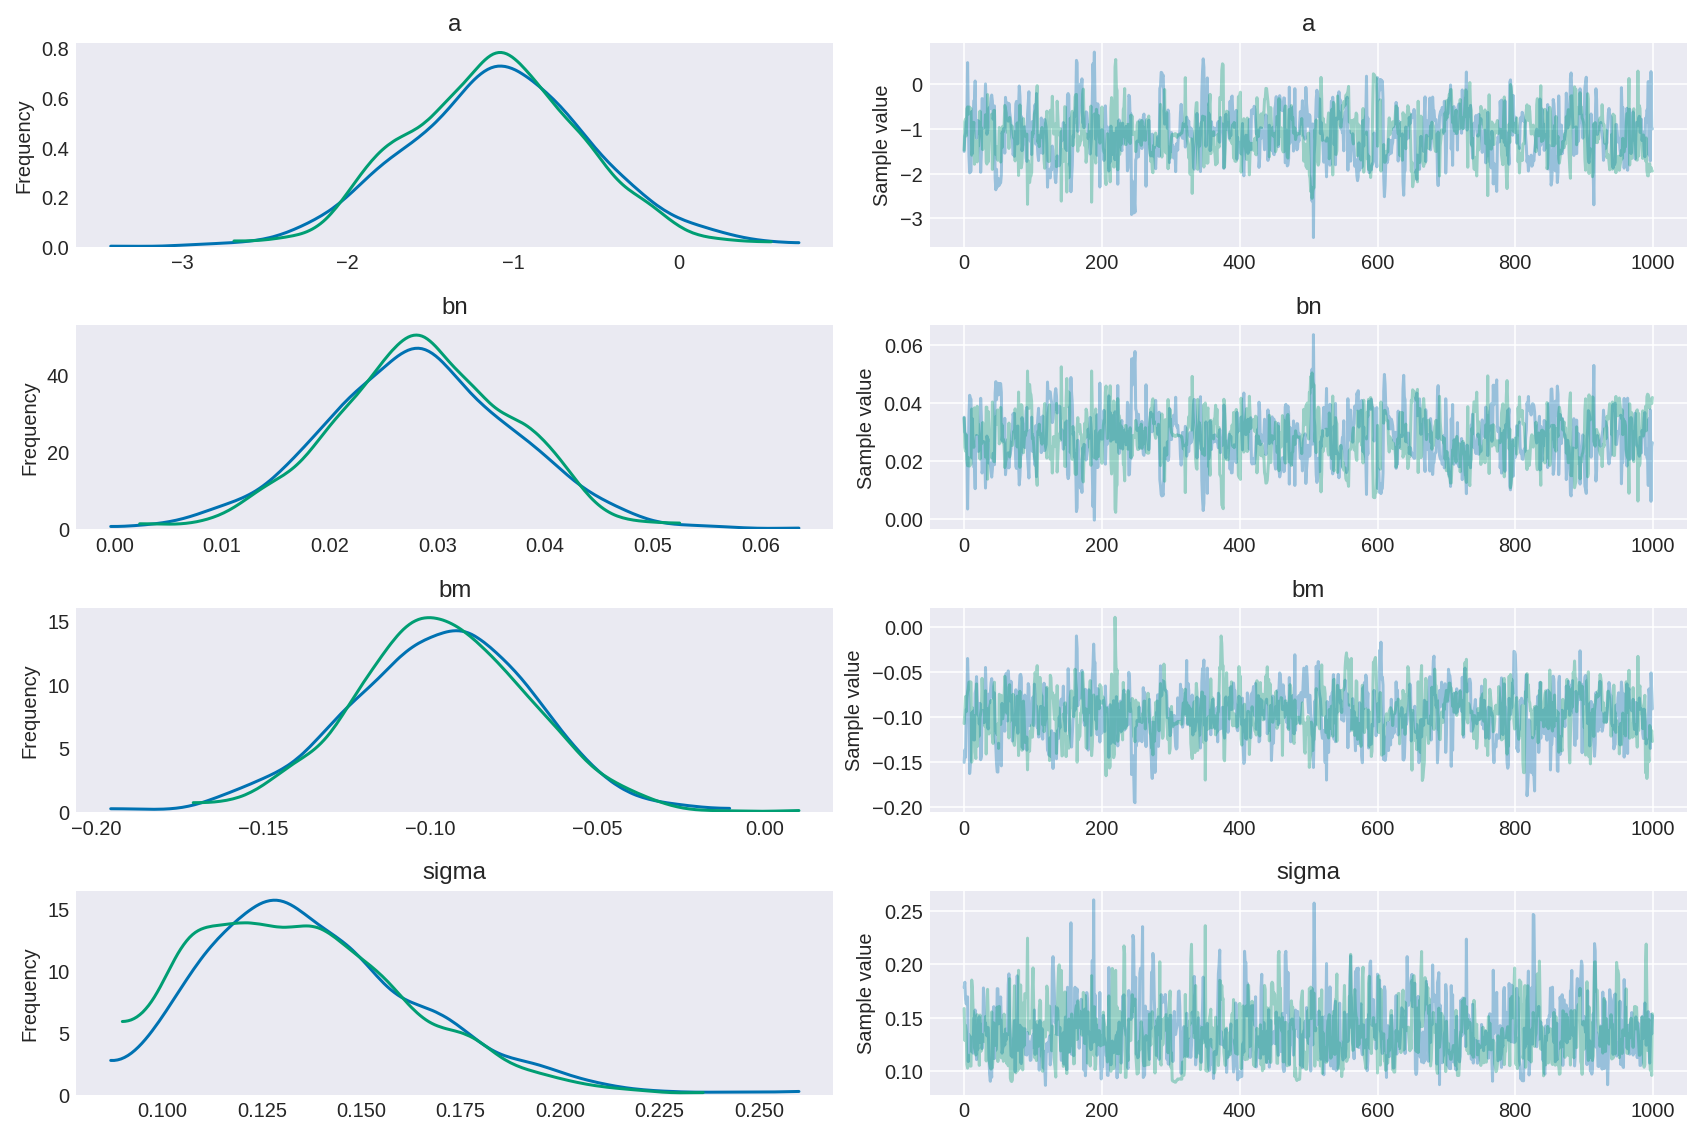

In [39]:
pm.traceplot(trace_5_7, ['a','bn','bm','sigma']);

#### Code 5.27

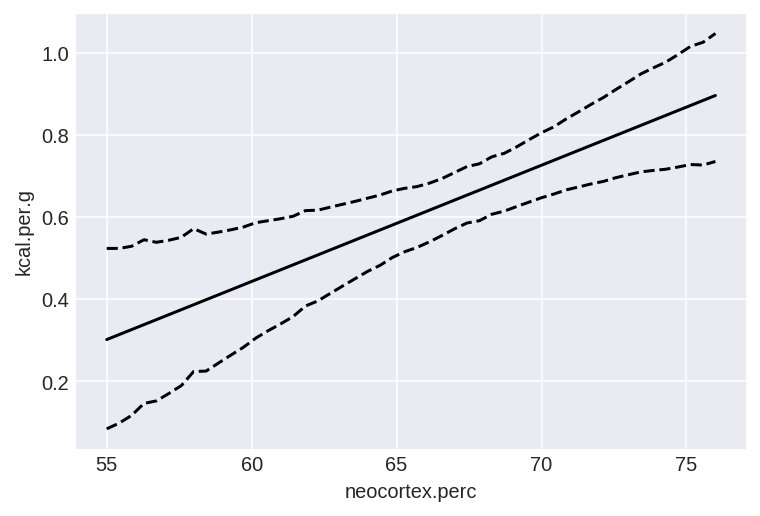

In [40]:
seq = np.linspace(55, 76, 50)
mu_pred = trace_5_7['a'] + trace_5_7['bn'] * seq[:,None] + trace_5_7['bm'] * dcc['log_mass'].mean()
mu_hpd = pm.hpd(mu_pred.T)

plt.plot(seq, mu_pred.mean(1), 'k')
plt.plot(seq, mu_hpd[:,0], 'k--')
plt.plot(seq, mu_hpd[:,1], 'k--')

plt.xlabel('neocortex.perc')
plt.ylabel('kcal.per.g');

#### Code 5.28

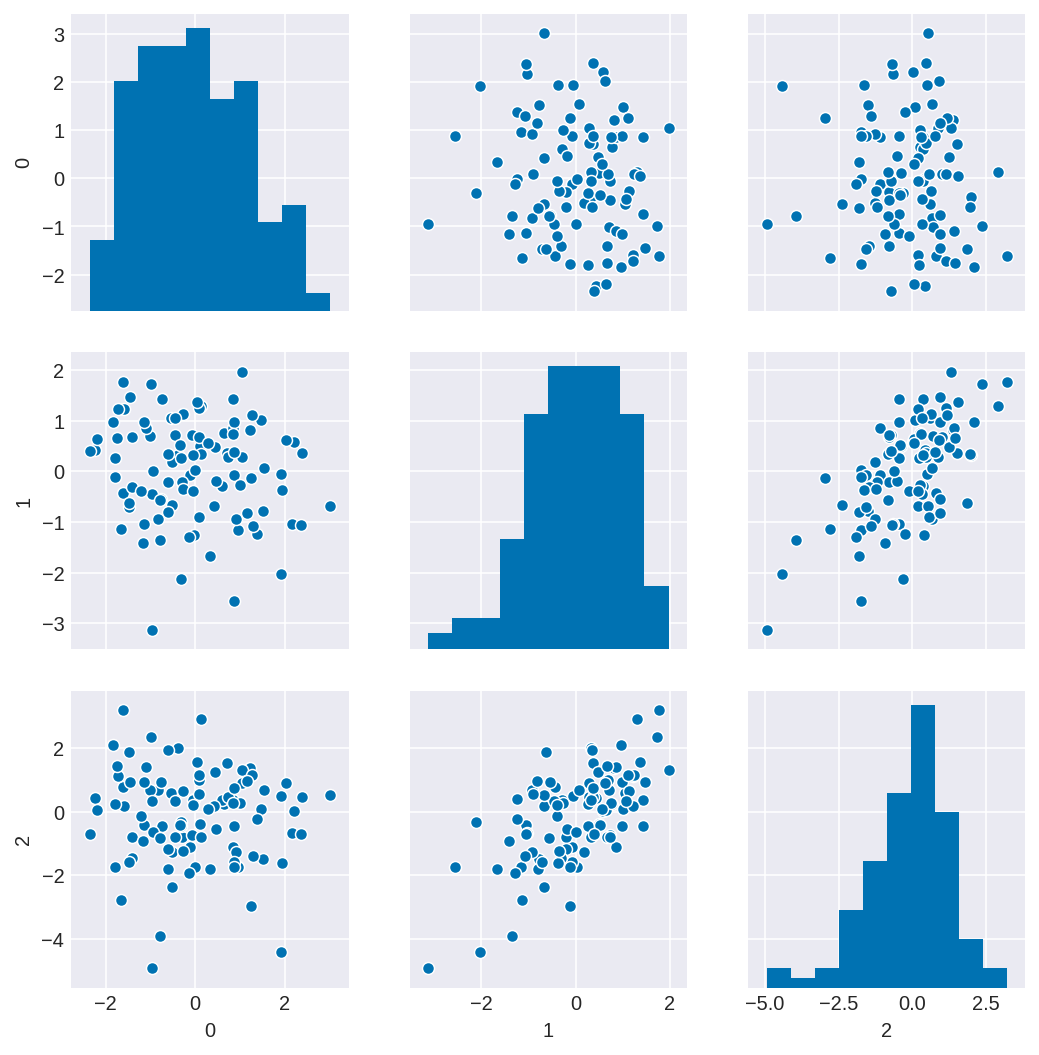

In [41]:
N = 100
rho = 0.7
x_pos = stats.norm.rvs(size=N)
x_neg = stats.norm.rvs(rho*x_pos, (1-rho**2)**0.5)
y = stats.norm.rvs(x_pos - x_neg)
d = pd.DataFrame([y, x_real, x_spur]).T

sns.pairplot(d);

#### Code 5.29

In [42]:
N = 100
height = stats.norm.rvs(size=N, loc=10, scale=2)
leg_prop = stats.uniform.rvs(size=N, loc=0.4, scale=0.5) 
leg_left = leg_prop * height + stats.norm.rvs(size=N, loc=0, scale=0.02)
leg_right = leg_prop * height + stats.norm.rvs(size=N, loc=0, scale=0.02)

#### Code 5.30

In [43]:
with pm.Model() as m5_8:
    a = pm.Normal('a', mu=10, sd=100)
    bl = pm.Normal('bl', mu=2, sd=10)
    br = pm.Normal('br', mu=2, sd=10)
    mu = pm.Deterministic('mu', a + bl * leg_left + br * leg_right)    
    sigma = pm.Uniform('sigma', lower=0 , upper=10)
    height_p = pm.Normal('height_p', mu=mu, sd=sigma, observed=height)    
    trace_5_8 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, br, bl, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [03:38<00:00, 18.32draws/s]


mean     sd  mc_error  hpd_5.5  hpd_94.5     n_eff   Rhat
a      5.905  0.467     0.012    5.225     6.679  1257.204  1.000
bl    -3.447  4.377     0.146  -10.315     3.577   781.083  1.001
br     4.090  4.381     0.147   -2.907    10.997   780.025  1.001
sigma  1.489  0.105     0.003    1.311     1.641  1147.157  1.000

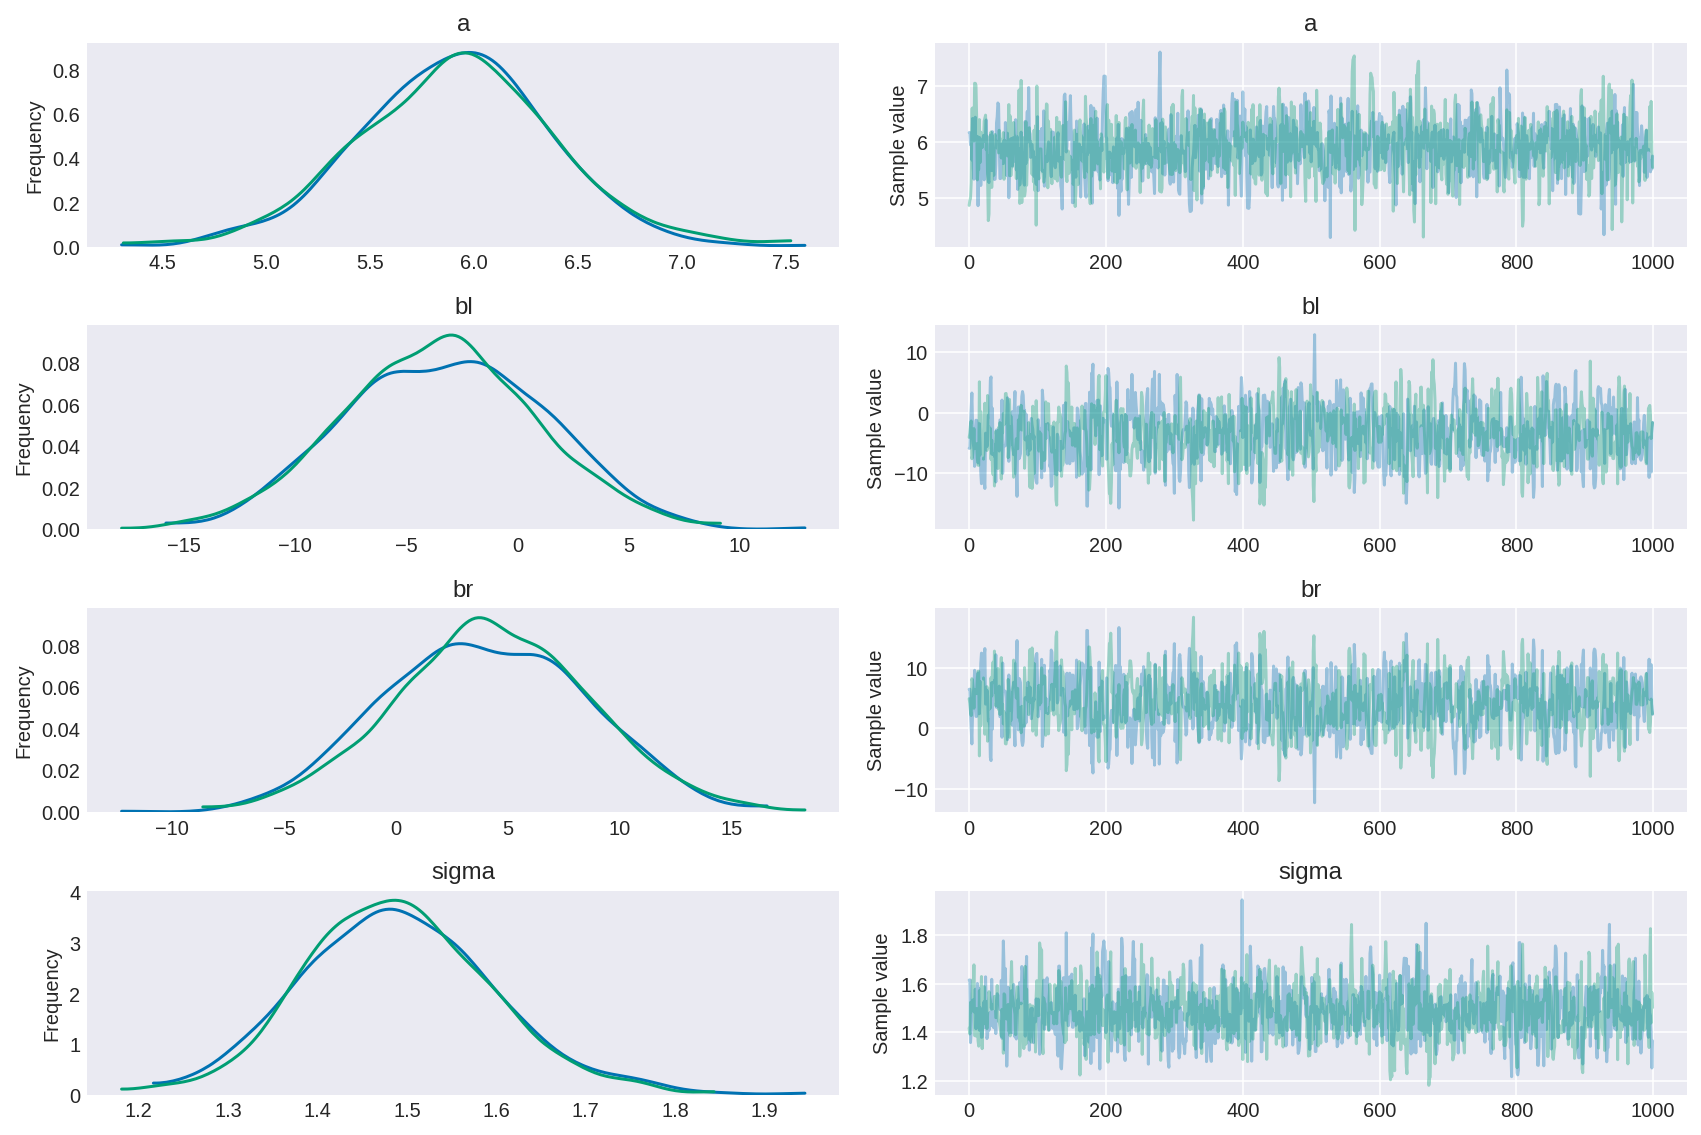

In [44]:
varnames=['a', 'bl', 'br', 'sigma']
pm.traceplot(trace_5_8, varnames);
pm.summary(trace_5_8, varnames, alpha=.11).round(3)

#### Code 5.31

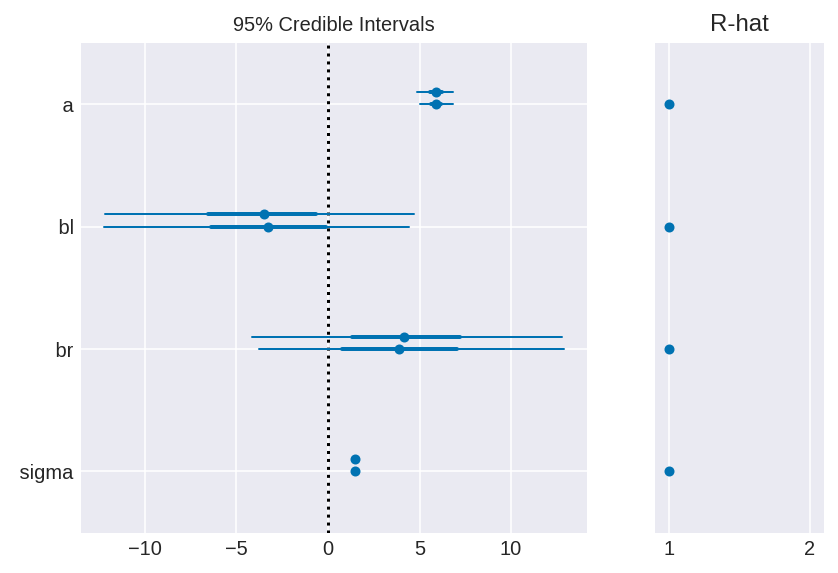

In [45]:
pm.forestplot(trace_5_8, varnames=varnames);

#### Code 5.32

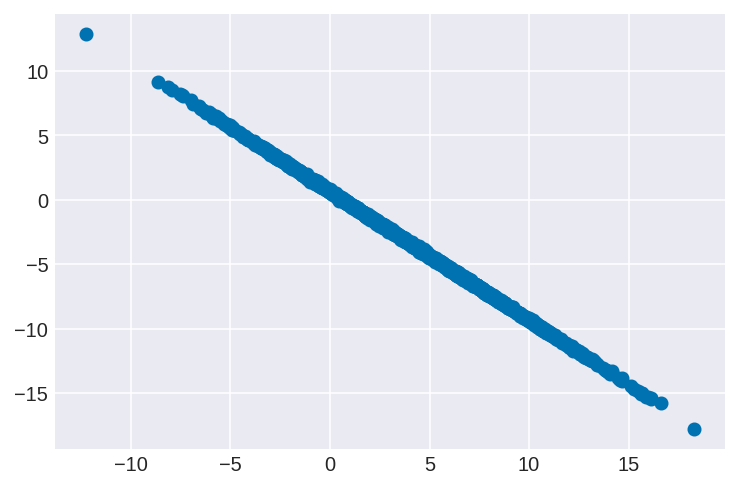

In [46]:
plt.scatter(trace_5_8['br'], trace_5_8['bl']);

#### Code 5.33

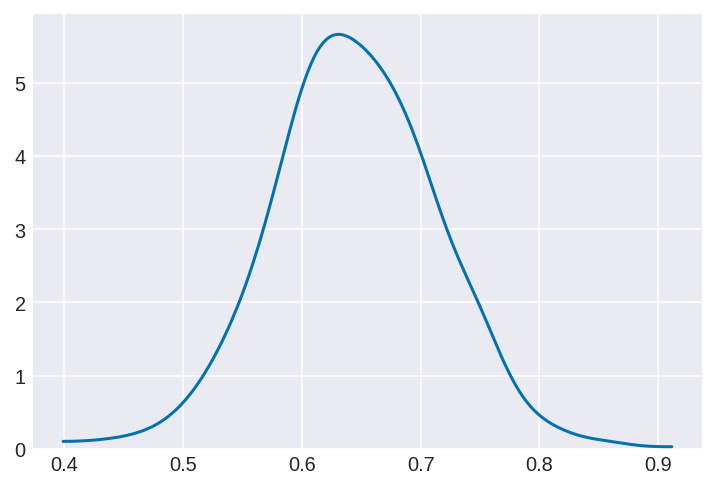

In [47]:
sum_blbr = trace_5_8['br'] + trace_5_8['bl']
pm.kdeplot(sum_blbr);

#### Code 5.34

In [48]:
with pm.Model() as m5_9:
    a = pm.Normal('a',mu = 10, sd=100)
    bl = pm.Normal('bl',mu=2, sd= 10)
    mu = pm.Deterministic('mu',a + bl * leg_left)    
    sigma = pm.Uniform('sigma', lower= 0 , upper= 10)
    height = pm.Normal('height',mu=mu, sd=sigma, observed=height)
    trace_5_9 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bl, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:05<00:00, 720.94draws/s]


mean     sd  mc_error  hpd_5.5  hpd_94.5    n_eff  Rhat
a      5.919  0.485     0.017    5.153     6.687  665.583   1.0
bl     0.640  0.073     0.003    0.509     0.744  643.214   1.0
sigma  1.493  0.113     0.003    1.318     1.668  996.984   1.0

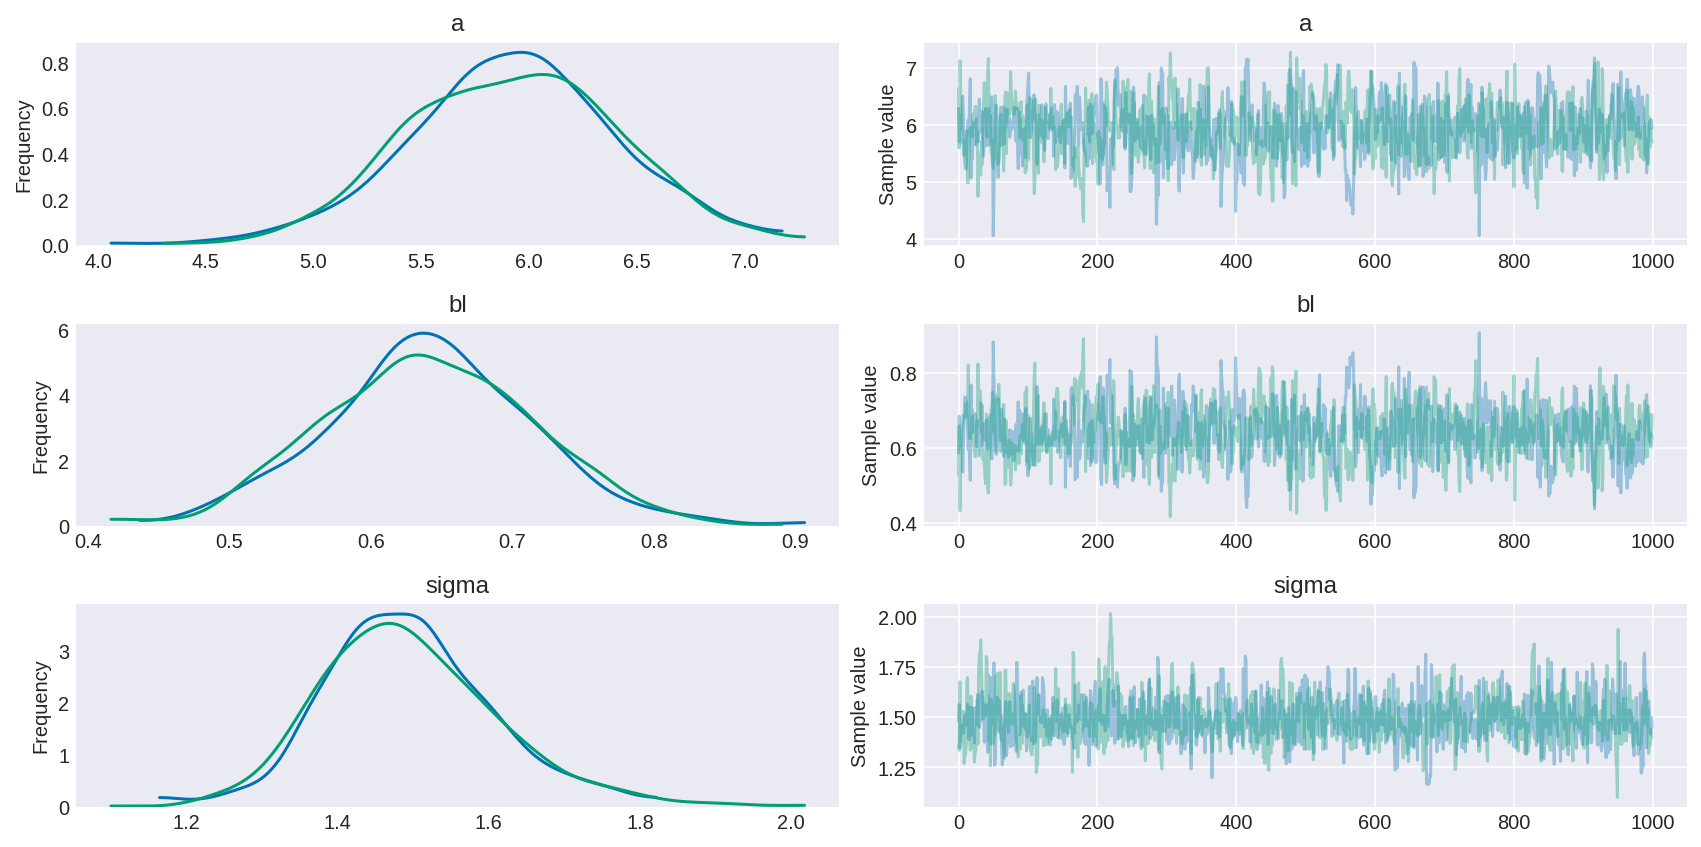

In [49]:
varnames_1 = ['a', 'bl', 'sigma']
pm.traceplot(trace_5_9, varnames_1)
pm.summary(trace_5_9, varnames_1, alpha=.11).round(3)

#### Code 5.35

In [50]:
milk = pd.read_csv('Data/milk.csv', sep=';')
milk.head()

clade         species  kcal.per.g  perc.fat  perc.protein  \
0  Strepsirrhine  Eulemur fulvus        0.49     16.60         15.42   
1  Strepsirrhine        E macaco        0.51     19.27         16.91   
2  Strepsirrhine        E mongoz        0.46     14.11         16.85   
3  Strepsirrhine   E rubriventer        0.48     14.91         13.18   
4  Strepsirrhine     Lemur catta        0.60     27.28         19.50   

   perc.lactose  mass  neocortex.perc  
0         67.98  1.95           55.16  
1         63.82  2.09             NaN  
2         69.04  2.51             NaN  
3         71.91  1.62             NaN  
4         53.22  2.19             NaN

#### Code 5.36

In [51]:
with pm.Model() as m5_10:
    a = pm.Normal('a',mu = 0.6, sd=10)
    bf = pm.Normal('bf',mu=0, sd= 1)
    mu = pm.Deterministic('mu',a + bf * milk['perc.fat'])    
    sigma = pm.Uniform('sigma', lower= 0 , upper= 10)
    kcalperg = pm.Normal('kcal.per.g',mu=mu, sd=sigma, observed=milk['kcal.per.g'])
    trace_5_10 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bf, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:07<00:00, 546.79draws/s] 
The acceptance probability does not match the target. It is 0.663147069955972, but should be close to 0.8. Try to increase the number of tuning steps.


In [52]:
varnames = ['a', 'bf', 'sigma']
pm.summary(trace_5_10, varnames, alpha=.11).round(3)

mean     sd  mc_error  hpd_5.5  hpd_94.5    n_eff  Rhat
a      0.302  0.038     0.001    0.245     0.367  789.966   1.0
bf     0.010  0.001     0.000    0.008     0.012  786.410   1.0
sigma  0.080  0.012     0.000    0.063     0.100  640.546   1.0

In [53]:
with pm.Model() as m5_11:
    a = pm.Normal('a',mu = 0.6, sd=10)
    bl = pm.Normal('bl',mu=0, sd= 1)
    mu = pm.Deterministic('mu',a + bl * milk['perc.lactose'])    
    sigma = pm.Uniform('sigma', lower= 0 , upper= 10)
    kcalperg = pm.Normal('kcal.per.g',mu=mu, sd=sigma, observed=milk['kcal.per.g'])
    trace_5_11 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bl, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:08<00:00, 483.70draws/s]


In [54]:
varnames = ['a', 'bl', 'sigma']
pm.summary(trace_5_11, varnames, alpha=.11).round(3)

mean     sd  mc_error  hpd_5.5  hpd_94.5    n_eff   Rhat
a      1.166  0.046     0.002    1.099     1.244  684.042  1.004
bl    -0.011  0.001     0.000   -0.012    -0.009  688.704  1.004
sigma  0.067  0.010     0.000    0.053     0.081  774.173  1.000

#### Code 5.37

In [55]:
with pm.Model() as m5_12:
    a = pm.Normal('a',mu = 0.6, sd=10)
    bf = pm.Normal('bf',mu=0, sd= 1)
    bl = pm.Normal('bl',mu=0, sd= 1)
    mu = pm.Deterministic('mu',a + bf * milk['perc.fat'] + bl * milk['perc.lactose'])    
    sigma = pm.Uniform('sigma', lower= 0 , upper= 10)
    kcalperg = pm.Normal('kcal.per.g',mu=mu, sd=sigma, observed=milk['kcal.per.g'])
    trace_5_12 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bl, bf, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:21<00:00, 186.24draws/s]
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7044013732177129, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


In [56]:
varnames = ['a', 'bf', 'bl', 'sigma']
pm.summary(trace_5_12, varnames, alpha=.11).round(3)

mean     sd  mc_error  hpd_5.5  hpd_94.5    n_eff   Rhat
a      1.009  0.230     0.011    0.642     1.379  394.731  1.001
bf     0.002  0.003     0.000   -0.002     0.007  403.921  1.001
bl    -0.009  0.003     0.000   -0.013    -0.004  407.631  1.001
sigma  0.068  0.010     0.000    0.052     0.082  448.124  1.001

#### Code 5.38

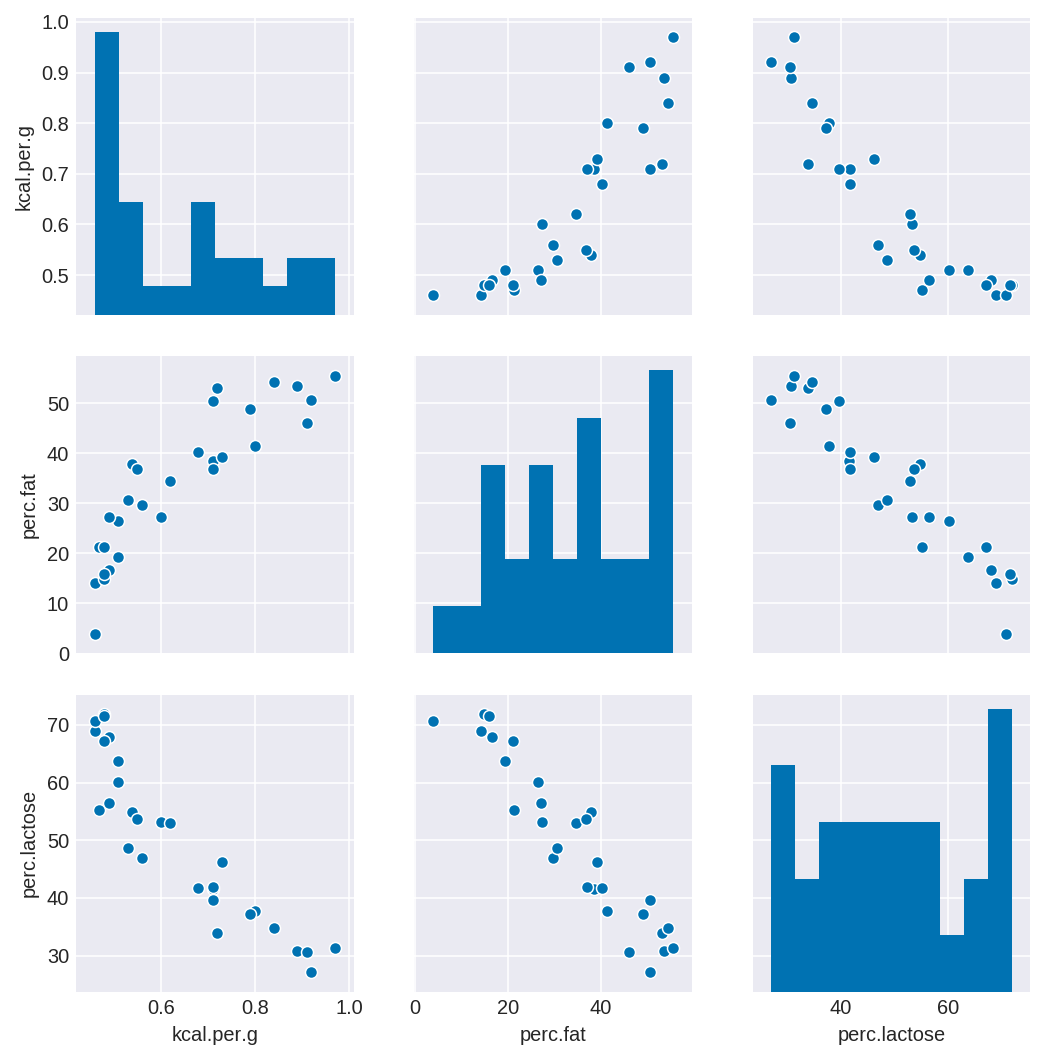

In [57]:
df = milk[['kcal.per.g','perc.fat','perc.lactose']]
sns.pairplot(df);

#### Code 5.39

In [58]:
milk.corr()['perc.fat']['perc.lactose']

-0.9416373456839282

#### Code 5.40

As the correlation between the parameters increases the standard deviation of the predictors inflates. This is a way to detect multicollinarity and quantifying it's effect. If we are in the inflated sigma region, then it's bad.

In [59]:
r=0.99
milk['x'] = stats.norm.rvs(size=len(milk), loc = r * milk['perc.fat'],
                   scale = np.sqrt((1 - r**2) * milk['perc.fat'].var()))
X = np.column_stack((milk['perc.fat'], milk['x']))
m = smf.OLS(milk['kcal.per.g'], X).fit()
cov = m.cov_params()
print(cov)
print((np.diag(cov)[1])**0.5)

          x1        x2
x1  0.000281 -0.000282
x2 -0.000282  0.000284
0.016846377463248245


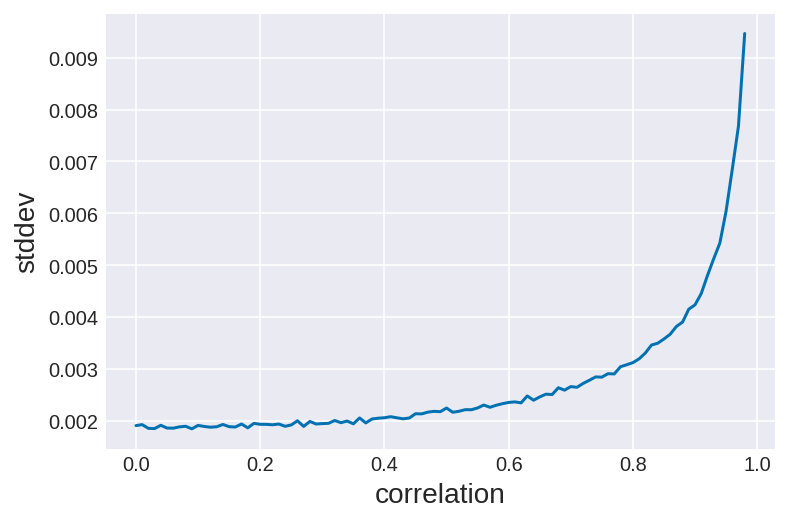

In [60]:
def simcoll(r = 0.9):
    milk['x'] = stats.norm.rvs(size=len(milk), loc = r * milk['perc.fat'],
                       scale = np.sqrt((1 - r**2) * milk['perc.fat'].var()))
    X = np.column_stack((milk['perc.fat'], milk['x']))
    m = smf.OLS(milk['kcal.per.g'], X).fit()
    cov = m.cov_params()
    return (np.diag(cov)[1])**0.5
    
def repsimcoll(r= 0.9, N = 100):
    stddev = [simcoll(r) for _ in range(N)]
    return np.mean(stddev)

lista = []
for i in np.arange(start = 0, stop = 0.99, step = 0.01):   
    lista.append(repsimcoll (r= i, N = 100))

plt.plot(np.arange(start = 0, stop = 0.99, step = 0.01), lista)
plt.xlabel('correlation', fontsize=14)
plt.ylabel('stddev', fontsize=14);

#### Code 5.41

In [61]:
# number of plants
N = 100

# simulate initial heights
h0 = stats.norm.rvs(size = N, loc = 10, scale = 2)

# assign treatments and simulate fungus and growth
treatment = np.repeat([0, 1], [N/2]*2)
fungus = np.random.binomial(n=1, p=(0.5-treatment * 0.4), size=N)
h1 = h0 + stats.norm.rvs(size= N, loc= 5- 3*fungus, scale=1)

# compose a clean data frame
d = pd.DataFrame({'h0': h0,
                  'h1': h1,
                  'Treatment':treatment,
                  'Fungus': fungus})
print(d.head())

         h0         h1  Treatment  Fungus
0  7.386764   9.862763          0       1
1  9.294139  15.102749          0       0
2  9.045034  12.612271          0       0
3  8.015094  11.149501          0       1
4  9.745081  15.122686          0       0


#### Code 5.42

In [62]:
with pm.Model() as m5_13:
    a = pm.Normal('a',mu = 0, sd=100)
    bh = pm.Normal('bh',mu = 0, sd=10)
    bt = pm.Normal('bt',mu = 0, sd=10)
    bf = pm.Normal('bf',mu = 0, sd=10)
    mu = pm.Deterministic('mu',a + bh * h0 + bt * treatment + bf * fungus)
    sigma = pm.Uniform('sigma', lower= 0 , upper= 10)
    h1 = pm.Normal('h1', mu = mu, sd=sigma, observed = d['h1'].get_values())
    trace_5_13 = pm.sample(1000, tune=1000) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bf, bt, bh, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:10<00:00, 381.17draws/s]
The acceptance probability does not match the target. It is 0.8876726371383902, but should be close to 0.8. Try to increase the number of tuning steps.


In [63]:
varnames = ['a', 'bh', 'bt', 'bf', 'sigma']
pm.summary(trace_5_13, varnames, alpha=.11).round(3)

mean     sd  mc_error  hpd_5.5  hpd_94.5     n_eff  Rhat
a      5.150  0.457     0.017    4.420     5.857   672.353   1.0
bh     0.984  0.042     0.002    0.919     1.049   754.122   1.0
bt    -0.098  0.214     0.006   -0.447     0.229  1320.668   1.0
bf    -2.708  0.248     0.006   -3.094    -2.302  1455.806   1.0
sigma  0.940  0.070     0.002    0.826     1.048  1617.264   1.0

#### Code 5.43

In [64]:
with pm.Model() as m5_14:
    a = pm.Normal('a',mu = 0, sd=100)
    bh = pm.Normal('bh',mu = 0, sd=10)
    bt = pm.Normal('bt',mu = 0, sd=10)
    mu = pm.Deterministic('mu',a + bh * h0 + bt * treatment)
    sigma = pm.Uniform('sigma', lower= 0 , upper= 10)
    h1 = pm.Normal('h1', mu = mu, sd=sigma, observed =d['h1'])
    trace_5_14 = pm.sample(1000, tune=1000) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bt, bh, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:07<00:00, 512.86draws/s]


In [65]:
varnames = ['a', 'bh', 'bt', 'sigma']
pm.summary(trace_5_14, varnames, alpha=.11).round(3)

mean     sd  mc_error  hpd_5.5  hpd_94.5     n_eff   Rhat
a      3.744  0.630     0.021    2.813     4.828   873.914  1.001
bh     1.011  0.059     0.002    0.918     1.106   870.123  1.001
bt     0.916  0.277     0.008    0.503     1.379  1581.161  1.000
sigma  1.400  0.105     0.003    1.223     1.551  1365.654  1.000

#### Code 5.44

In [66]:
d = pd.read_csv('Data/Howell1.csv', sep=';')
d.head()

height     weight   age  male
0  151.765  47.825606  63.0     1
1  139.700  36.485807  63.0     0
2  136.525  31.864838  65.0     0
3  156.845  53.041915  41.0     1
4  145.415  41.276872  51.0     0

#### Code 5.45

In [67]:
with pm.Model() as m5_15:
    a = pm.Normal('a',mu = 178, sd=100)
    bm = pm.Normal('bm',mu = 0, sd=10)
    mu = pm.Deterministic('mu',a + bm * d['male'])
    sigma = pm.Uniform('sigma', lower= 0 , upper= 50)
    height = pm.Normal('height', mu = mu, sd=sigma, observed = d['height'])
    trace_5_15 = pm.sample(1000, tune=1000) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bm, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:03<00:00, 1139.57draws/s]


In [68]:
varnames = ['a', 'bm', 'sigma']
pm.summary(trace_5_15, varnames, alpha=.11).round(3)

mean     sd  mc_error  hpd_5.5  hpd_94.5     n_eff  Rhat
a      134.806  1.622     0.052  132.265   137.337   908.302   1.0
bm       7.283  2.398     0.076    3.404    10.966   959.461   1.0
sigma   27.430  0.840     0.019   25.972    28.645  1679.797   1.0

#### Code 5.46

In [69]:
mu.male = trace_5_15['a'] + trace_5_15['bm']
pm.hpd(mu.male)

array([138.81995893, 145.64668863])

#### Code 5.47

In [70]:
with pm.Model() as m5_15b:
    af = pm.Normal('af',mu = 178, sd=100)
    am = pm.Normal('am',mu = 178, sd=100)
    mu = pm.Deterministic('mu',af * (1 - d['male']) + am * d['male'])
    sigma = pm.Uniform('sigma', lower= 0 , upper= 50)
    height = pm.Normal('height', mu = mu, sd=sigma, observed = d['height'])
    trace_5_15b = pm.sample(1000, tune=1000) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, am, af]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:02<00:00, 1558.64draws/s]


In [71]:
varnames = ['af', 'am', 'sigma']
pm.summary(trace_5_15b, varnames, alpha=.11).round(3)

mean     sd  mc_error  hpd_5.5  hpd_94.5     n_eff  Rhat
af     134.593  1.651     0.034  132.061   137.248  2608.328   1.0
am     142.388  1.672     0.029  139.699   144.963  3014.907   1.0
sigma   27.397  0.820     0.014   26.030    28.644  2578.182   1.0

#### Code 5.48

In [72]:
d = pd.read_csv('Data/milk.csv', sep=';')
d = d.drop_duplicates()

#### Code 5.49

In [73]:
d['clade.NWM'] = np.where( d['clade'] == 'New World Monkey', 1, 0)
d['clade.NWM'].get_values()

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0])

#### Code 5.50

In [74]:
d['clade.OWM'] = np.where( d['clade'] == 'Old World Monkey', 1, 0)
d['clade.S'] = np.where( d['clade'] == 'Strepsirrhine', 1, 0)

In [75]:
d.clade.unique()

array(['Strepsirrhine', 'New World Monkey', 'Old World Monkey', 'Ape'],
      dtype=object)

There are 4 different kinds of monkeys but we encoded only 3 of them. This is because one will be encoded by the intercept. If we encode all four of them our model will be unidentifiable. 

#### Code 5.51

In [76]:
with pm.Model() as m5_16:
    a = pm.Normal('a', mu = 0.6, sd=10)
    b_NWM = pm.Normal('b_NWM',mu = 0, sd=1)
    b_OWM = pm.Normal('b_OWM',mu = 0, sd=1)
    b_S = pm.Normal('b_S',mu = 0, sd=1)
    mu = pm.Deterministic('mu', a + 
                          b_NWM * d['clade.NWM'] + 
                          b_OWM * d['clade.OWM'] +
                          b_S * d['clade.S'])    
    # instead of adding this as a deterministic when running the model 
    # it is possible to add them, after sampling using something like this
    # trace_5_16.add_values({'mu_NWM', trace_5_16[a] + trace_5_16['b_NWM']})
    mu_ape = pm.Deterministic('mu_ape', a + 0)
    mu_NWM = pm.Deterministic('mu_NWM', a + b_NWM)
    mu_OWM = pm.Deterministic('mu_OWM', a + b_OWM)
    mu_S =  pm.Deterministic('mu_S', a + b_S)
    
    sigma = pm.Uniform('sigma', lower= 0 , upper= 10)
    kcal_per_g = pm.Normal('kcal_per_g', mu = mu, sd=sigma, observed = d['kcal.per.g'])
    trace_5_16 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b_S, b_OWM, b_NWM, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:04<00:00, 942.61draws/s] 


In [77]:
varnames = ['a', 'b_NWM', 'b_OWM', 'b_S', 'sigma']
pm.summary(trace_5_16, varnames, alpha=.11).round(3)

mean     sd  mc_error  hpd_5.5  hpd_94.5     n_eff   Rhat
a      0.547  0.044     0.002    0.478     0.615   854.787  1.000
b_NWM  0.168  0.061     0.002    0.075     0.263   946.305  1.001
b_OWM  0.241  0.070     0.002    0.133     0.350   989.984  1.000
b_S   -0.039  0.072     0.002   -0.156     0.071  1118.397  1.000
sigma  0.130  0.020     0.001    0.097     0.158  1273.790  1.002

#### Code 5.52

In [78]:
df_5_52 = pd.DataFrame({
                  'mu.ape' : [np.mean(trace_5_16['a']),
                              np.std(trace_5_16['a']),
                              pm.hpd(trace_5_16['a'], alpha=0.11)[0],
                              pm.hpd(trace_5_16['a'], alpha=0.11)[1]],         
                  'mu.NWM' : [np.mean(trace_5_16['a'] + trace_5_16['b_NWM']), 
                              np.std(trace_5_16['a'] + trace_5_16['b_NWM']),
                              pm.hpd(trace_5_16['a'] + trace_5_16['b_NWM'], alpha=0.11)[0],
                              pm.hpd(trace_5_16['a'] + trace_5_16['b_NWM'], alpha=0.11)[1]],
                  'mu.OWM' : [np.mean(trace_5_16['a'] + trace_5_16['b_OWM']), 
                              np.std(trace_5_16['a'] + trace_5_16['b_OWM']),
                              pm.hpd(trace_5_16['a'] + trace_5_16['b_OWM'], alpha=0.11)[0],
                              pm.hpd(trace_5_16['a'] + trace_5_16['b_OWM'], alpha=0.11)[1]],
                  'mu.S' : [np.mean(trace_5_16['a'] + trace_5_16['b_S']),
                            np.std(trace_5_16['a'] + trace_5_16['b_S']),
                            pm.hpd(trace_5_16['a'] + trace_5_16['b_S'], alpha=0.11)[0],
                            pm.hpd(trace_5_16['a'] + trace_5_16['b_S'], alpha=0.11)[1]]
                        },
                  index=['Mean','StdDev','|0.89','0.89|'])
print(df_5_52.round(2).T)

        Mean  StdDev  |0.89  0.89|
mu.ape  0.55    0.04   0.48   0.62
mu.NWM  0.71    0.04   0.64   0.77
mu.OWM  0.79    0.05   0.71   0.88
mu.S    0.51    0.06   0.42   0.60


#### Code 5.53

difference between monkey groups

In [79]:
diff_NMW_OWM = trace_5_16['mu_NWM'] - trace_5_16['mu_OWM']
np.percentile(diff_NMW_OWM, 2.5), np.percentile(diff_NMW_OWM, 50), np.percentile(diff_NMW_OWM, 97.5)

(-0.20881099383367396, -0.07404345615216557, 0.06062681380628964)

#### Code 5.54

In [80]:
z = pd.Categorical(d['clade'])
d['clade_id'] = z.codes

#### Code 5.55

In [81]:
with pm.Model() as m5_16_alt:
    a = pm.Normal('a',mu = 0.6, sd=10, shape=len(d['clade_id'].unique()))
    sigma = pm.Uniform('sigma', lower= 0 , upper= 10)
    kcal_per_g = pm.Normal('kcal_per_g', mu = a[d['clade_id'].values], sd=sigma, observed = d['kcal.per.g'])
    trace_5_16_alt = pm.sample(1000, tune=1000) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:03<00:00, 1244.99draws/s]


In [82]:
varnames = ['a', 'sigma']
pm.summary(trace_5_16_alt, varnames, alpha=.11)

mean        sd  mc_error   hpd_5.5  hpd_94.5        n_eff      Rhat
a__0   0.545499  0.044163  0.000941  0.476651  0.614059  2436.890231  0.999685
a__1   0.715473  0.045223  0.001042  0.643204  0.784518  1774.763757  0.999501
a__2   0.786957  0.053475  0.001328  0.700745  0.864004  1842.552359  0.999639
a__3   0.509418  0.057509  0.001440  0.427127  0.608913  2034.295737  0.999706
sigma  0.130123  0.019767  0.000530  0.098533  0.159725  1332.777268  0.999561

The following cells (5.56-5.61) correspond to example code for the use of R's function: lm. Therefore they have no output.

#### Code 5.62

In [83]:
data  = pd.read_csv('Data/cars.csv', sep=',') 
pm.GLM.from_formula('dist ~ speed', data=data)

In [84]:
import sys, IPython, scipy, matplotlib, platform
print("This notebook was createad on a computer %s running %s and using:\nPython %s\nIPython %s\nPyMC3 %s\nNumPy %s\nPandas %s\nSciPy %s\nMatplotlib %s\nSeaborn %s\n" % (platform.machine(), ' '.join(platform.linux_distribution()[:2]), sys.version[:5], IPython.__version__, pm.__version__, np.__version__, pd.__version__, scipy.__version__, matplotlib.__version__, sns.__version__))

This notebook was createad on a computer x86_64 running debian stretch/sid and using:
Python 3.7.2
IPython 7.2.0
PyMC3 3.6
NumPy 1.16.0
Pandas 0.23.4
SciPy 1.2.0
Matplotlib 3.0.2
Seaborn 0.9.0



/home/damianos/.conda/envs/pymc3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: dist() and linux_distribution() functions are deprecated in Python 3.5
  
